In [20]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcdefaults()
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['text.color'] = '#909090'
mpl.rcParams['axes.labelcolor']= '#909090'
mpl.rcParams['xtick.color'] = '#909090'
mpl.rcParams['ytick.color'] = '#909090'
mpl.rcParams['font.size'] = 14

from scipy.stats import pearsonr

In [2]:
snapshot_mean = np.load('POD_Snapshot_Mean.npy')
pod_modes = np.load('POD_Modes_Trunc.npy')
lats = np.load('lat.npy')
lons = np.load('lon.npy')

In [21]:
# Reconstruct true
trunc_true = np.load('POD_Coeffs_test.npy')
print(trunc_true.shape)

trunc_pred = np.load('RKHS_Test_Prediction.npy')
# trunc_pred = np.concatenate((trunc_true[:,0:1],trunc_pred),axis=-1)
print(trunc_pred.shape)

# Load land mask
mask = np.load('./mask.npy').reshape(808,782)

(20, 2555)
(20, 2555)


In [22]:
#-------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------
# Visualize DayMet dataset
#-------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------
def visualize_predictions_pod(cf_pred,cf_true,sm,phi):

    #Visualization of state predictions for 4 modes
    
    
    for mode_num in range(20):
        fig,ax = plt.subplots(nrows=1)
        ax.plot(cf_true[mode_num,:],label='Truth')
        ax.plot(cf_pred[mode_num,:],label='POD-RKHS')
        
        if mode_num == 0:
            plt.legend(loc='lower left')
        
        plt.title('Forecast')
        plt.xlabel('Test Days')
        plt.ylabel('Magnitude')
        plt.tight_layout()
        plt.savefig('Lineplot_Mode_'+str(mode_num)+'.png')
        plt.show()
   
    dim_0 = 2555 #np.shape(snapshots)[0]
    dim_1 = 808 #np.shape(snapshots)[1]
    dim_2 = 782 #np.shape(snapshots)[2]

    # Reconstruct
    prediction = sm+np.transpose(np.matmul(phi,cf_pred))
    true_pod = sm+np.transpose(np.matmul(phi,cf_true))

    snapshots_pod = np.zeros(shape=(dim_0,dim_1*dim_2))
    snapshots_pred = np.zeros(shape=(dim_0,dim_1*dim_2))

    snapshots_pod[:,mask] = true_pod[:,:]
    snapshots_pred[:,mask] = prediction[:,:]

    snapshots_pod = snapshots_pod.reshape(dim_0,dim_1,dim_2)
    snapshots_pred = snapshots_pred.reshape(dim_0,dim_1,dim_2)
    
    return snapshots_pod, snapshots_pred

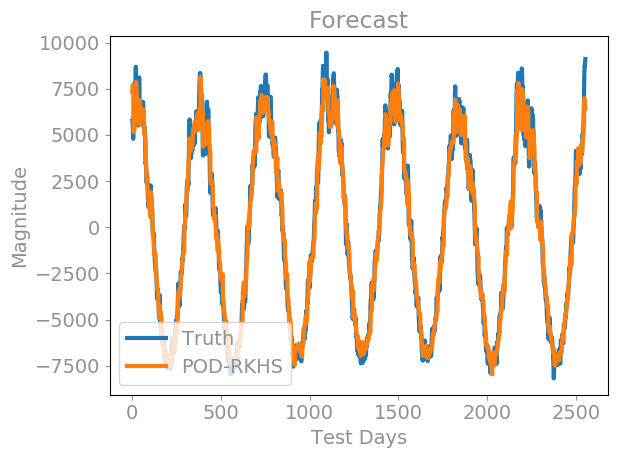

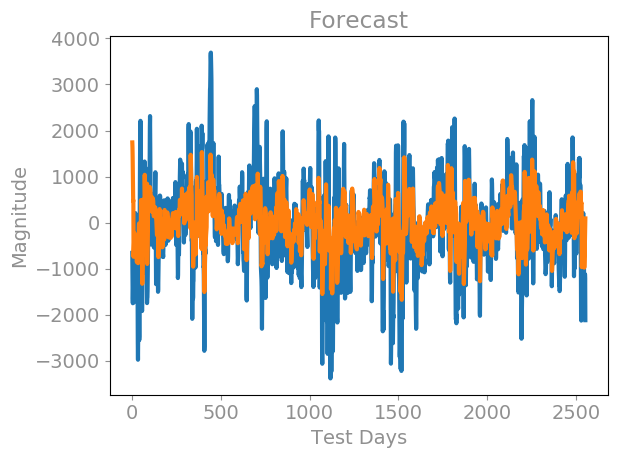

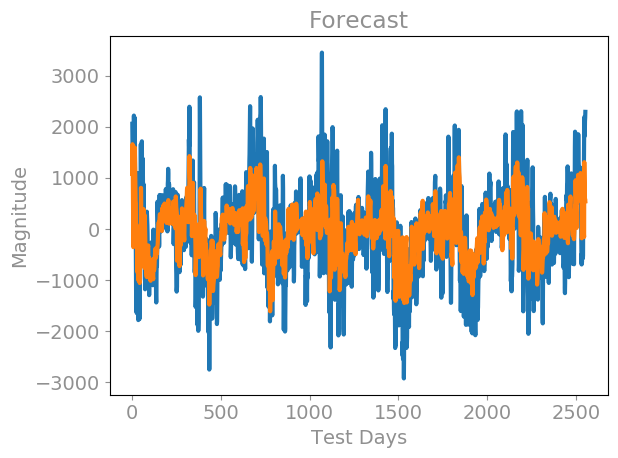

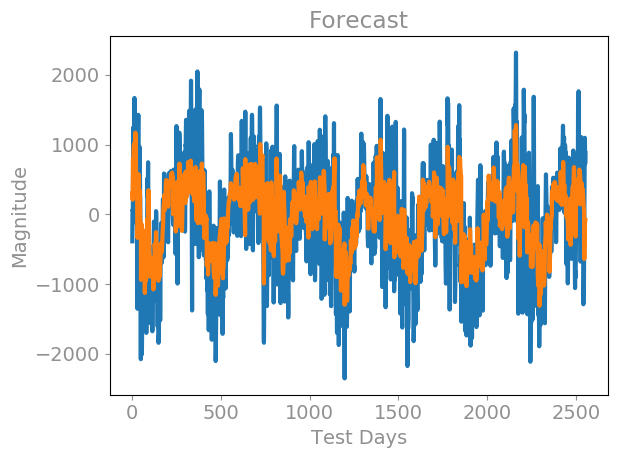

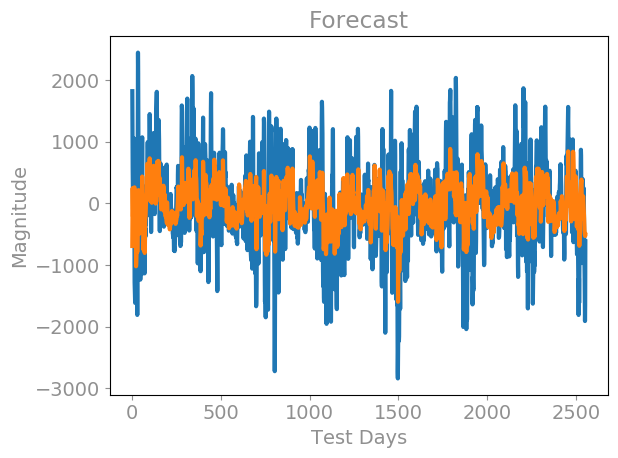

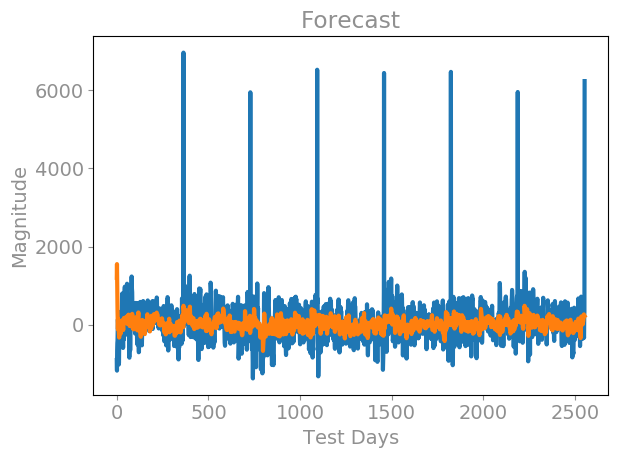

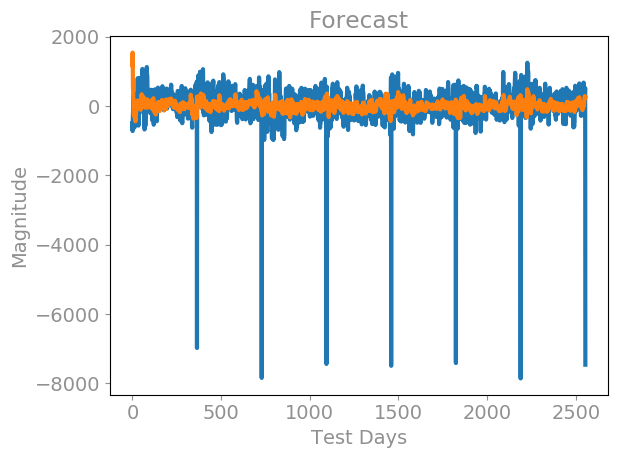

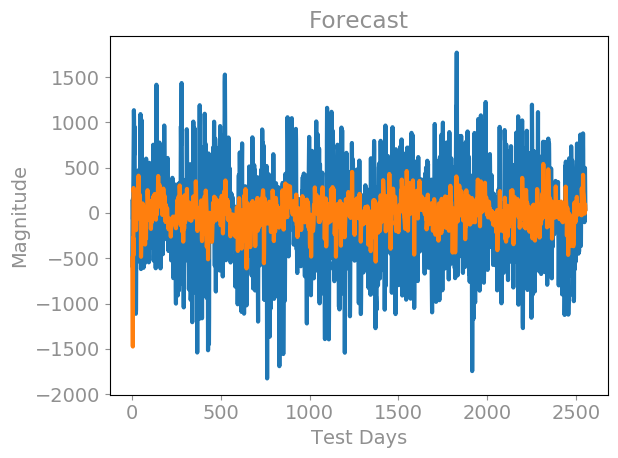

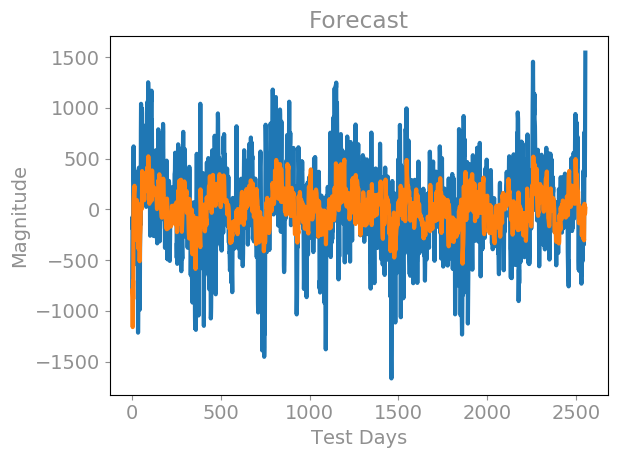

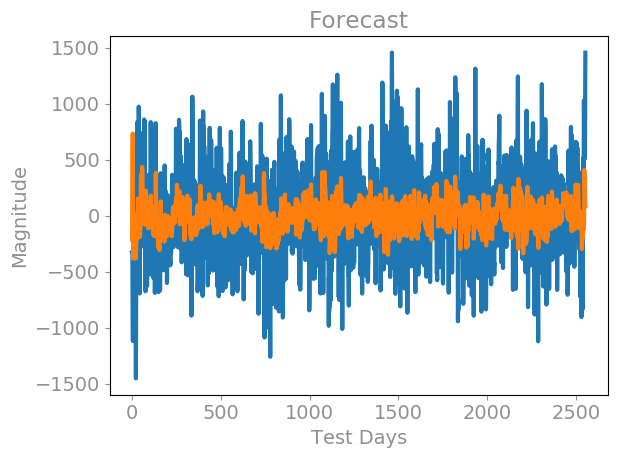

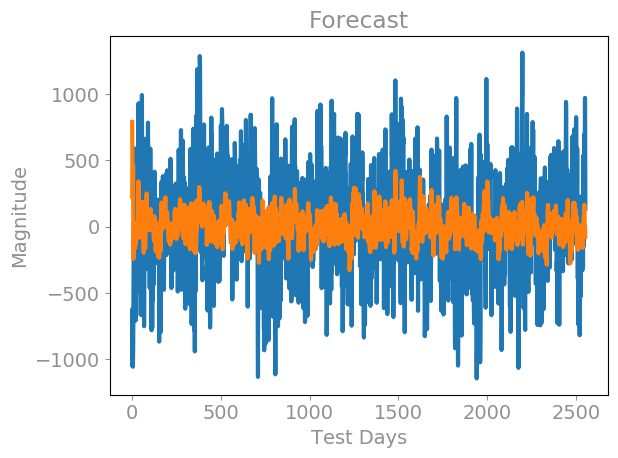

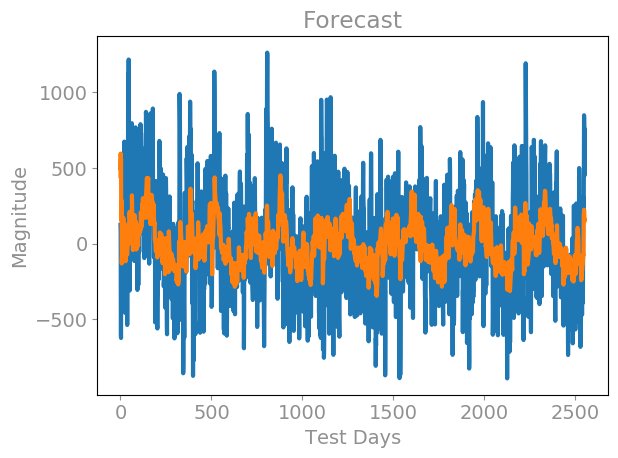

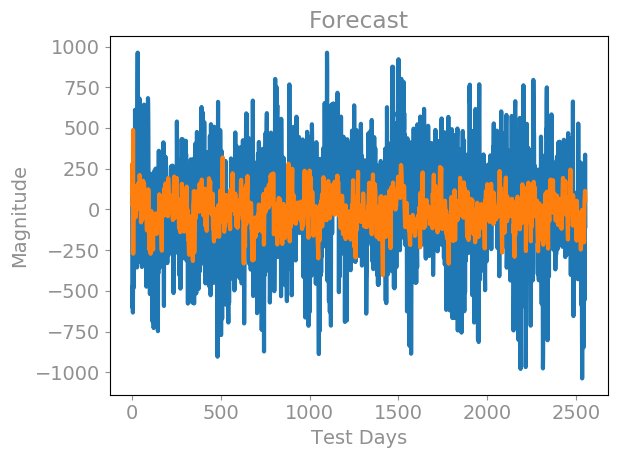

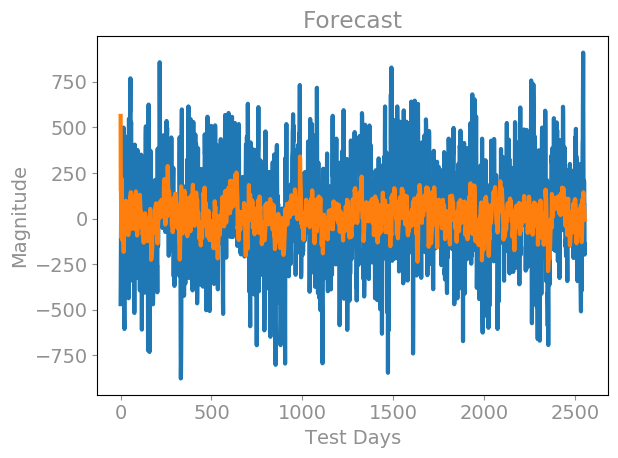

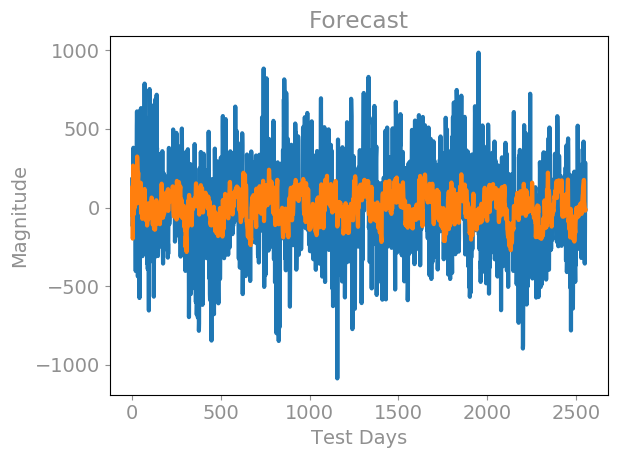

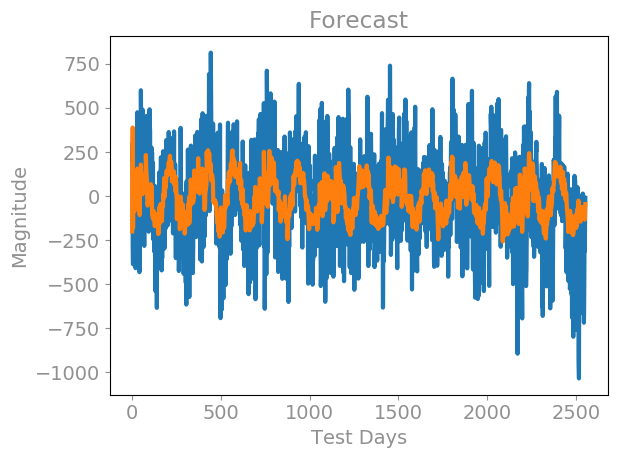

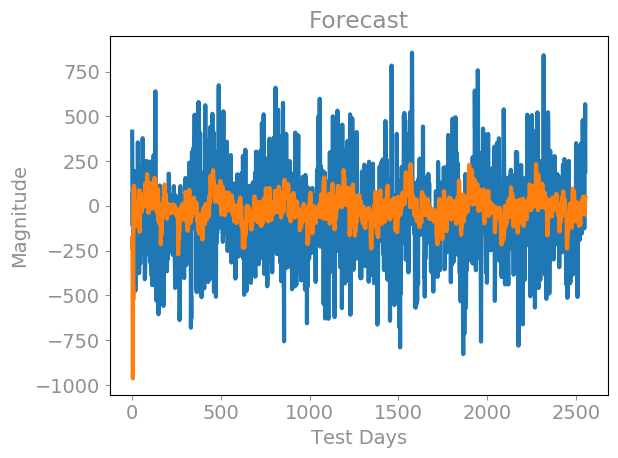

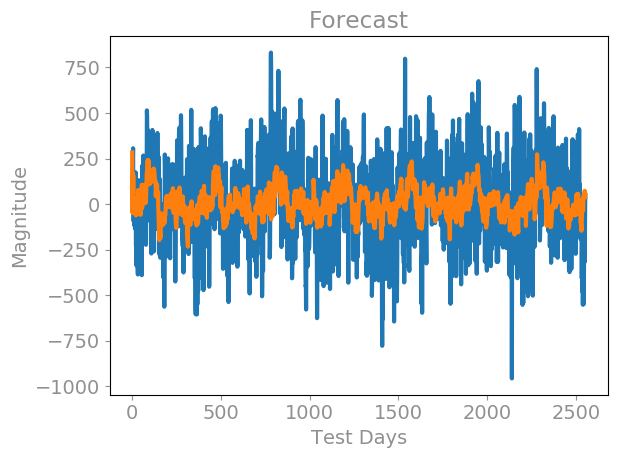

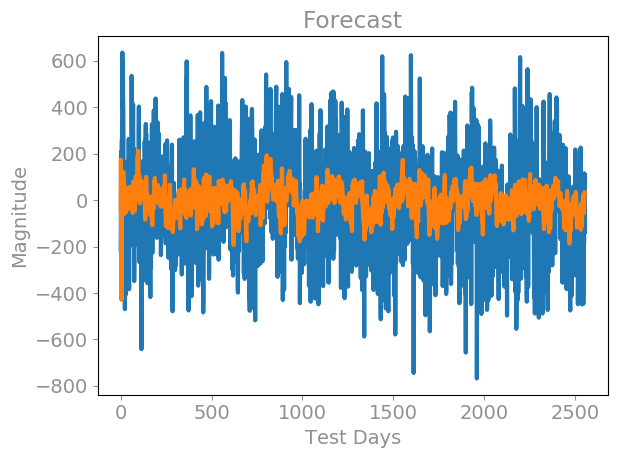

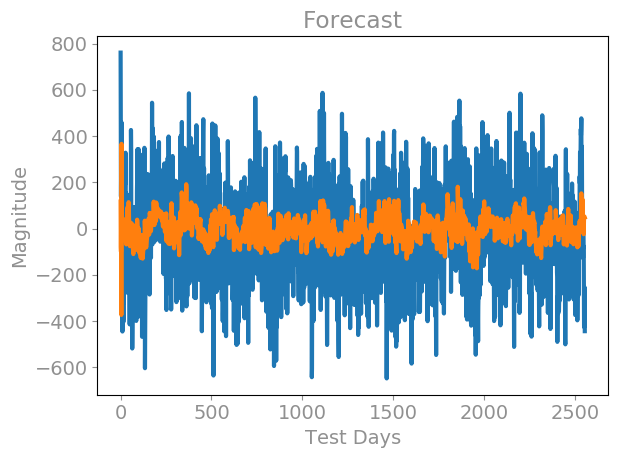

IndexError: too many indices for array

In [23]:
snapshots_pod, snapshots_pred = visualize_predictions_pod(trunc_pred,trunc_true,snapshot_mean,pod_modes)

In [6]:
# Load climatology baseline
training_snapshots = np.load('/home/rmaulik/link_dir/rmaulik/DayMet/tmax_dir/Data/Daymet_total_tmax.npy')[:11*365].astype('float64') # Training
climatology = np.zeros(shape=(365,np.shape(training_snapshots)[1],np.shape(training_snapshots)[2]))
for year in range(11):
    climatology = climatology+training_snapshots[year*365:(year+1)*365]
climatology = climatology/11.0

In [7]:
# Load true test
true_snapshots = np.load('/home/rmaulik/link_dir/rmaulik/DayMet/tmax_dir/Data/Daymet_total_tmax.npy')[11*365:].astype('float64') # Testing

In [8]:
save_preds = False
if save_preds:
    for i in range(8):
        np.save('Pred_'+str(2011+i)+'.npy',snapshots_pred[i*365:(i+1)*365])
        np.save('True_'+str(2011+i)+'.npy',true_snapshots[i*365:(i+1)*365])

In [63]:
levels = np.arange(-40,40,step=5)
from scipy import spatial

def probe_func(x,y,loc_name):
    
    print('Longitude:',lons[x,y])
    print('Latitude:',lats[x,y])
    
    plt.figure(figsize=(10,10))
    plt.contourf(lons,lats,true_snapshots[0,:,:],levels=levels)
    plt.scatter(lons[x,y],lats[x,y],color='red',label='Probe Location')
    plt.xlim((-180,-50))
    plt.ylim((10,90))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()
    
    for year in range(7):
        fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,7))
        
        ax[0].plot(snapshots_pred[year*365:(year+1)*365,x,y],label='Predicted')
        ax[0].plot(true_snapshots[year*365:(year+1)*365,x,y],label='True')
        
        ax[1].plot(climatology[:,x,y],label='Climatology')
        ax[1].plot(true_snapshots[year*365:(year+1)*365,x,y],label='True')
        
        ax[0].set_ylabel('Temperature (celsius)')
        ax[0].set_xlabel('Days in testing range')
        ax[1].set_xlabel('Days in testing range')
        
        ax[0].legend()
        ax[1].legend()
        
        fig.suptitle('Year '+str(2011+year)+' forecast')
        plt.tight_layout()
        fig.subplots_adjust(top=0.88)
        plt.show()
        
        print('Predicted cosine similarity:'\
              ,1-spatial.distance.cosine(true_snapshots[year*365:(year+1)*365,x,y]\
                                         ,snapshots_pred[year*365:(year+1)*365,x,y]))
        
        print('Climatology cosine similarity:'\
              ,1-spatial.distance.cosine(true_snapshots[year*365:(year+1)*365,x,y]\
                                         ,climatology[:,x,y]))

    year = 0    
    clim_preds = np.abs(climatology[:,x,y]-snapshots_pred[year*365:(year+1)*365,x,y])
    clim_true = np.abs(climatology[:,x,y]-true_snapshots[year*365:(year+1)*365,x,y])

    for year in range(1,7):
        clim_preds_temp = np.abs(climatology[:,x,y]-snapshots_pred[year*365:(year+1)*365,x,y])
        clim_true_temp = np.abs(climatology[:,x,y]-true_snapshots[year*365:(year+1)*365,x,y])
        
        clim_preds = np.concatenate((clim_preds,clim_preds_temp))
        clim_true = np.concatenate((clim_preds,clim_true_temp))

    plt.figure()
    plt.hist(np.hstack(clim_preds),label='Predicted',bins=20,alpha=0.5)
    plt.hist(np.hstack(clim_true),label='Climatology',bins=20,alpha=0.5)
    plt.legend()
    plt.ylabel('Instances')
    plt.xlabel('Bias magnitude')
    plt.title('Bias densities')
    plt.show()
    
def lat_lon_func(i,j):
    print('Latitude:',lats[i,j])
    print('Longitude:',lons[i,j])
    
    
def correlation_plot(year,int_start,int_end):
    # Finding the Pearson correlation (without time lag)    
    pred_vals = snapshots_pred[year*365+int_start:year*365+int_end].reshape(int_end-int_start,-1)[:,mask.flatten()]
    true_vals = true_snapshots[year*365+int_start:year*365+int_end].reshape(int_end-int_start,-1)[:,mask.flatten()]
    corr_vals_r = np.zeros(shape=(1,pred_vals.shape[-1]))
    corr_vals_p = np.zeros(shape=(1,pred_vals.shape[-1]))
        
    for location in range(true_vals.shape[-1]):
        corr_vals_r[0,location], corr_vals_p[0,location] = pearsonr(pred_vals[:,location],true_vals[:,location])
        
    corr_plot_r = np.copy(true_snapshots[0]).reshape(1,-1)
    corr_plot_r[0,mask.flatten()] = corr_vals_r[0]
    
    corr_plot_p = np.copy(true_snapshots[0]).reshape(1,-1)
    corr_plot_p[0,mask.flatten()] = corr_vals_p[0]
        
    return corr_plot_r.reshape(808,782), corr_plot_p.reshape(808,782)

In [64]:
lat_lon_func(499,551)

Latitude: 41.796146
Longitude: -87.97804


Longitude: -87.97804
Latitude: 41.796146


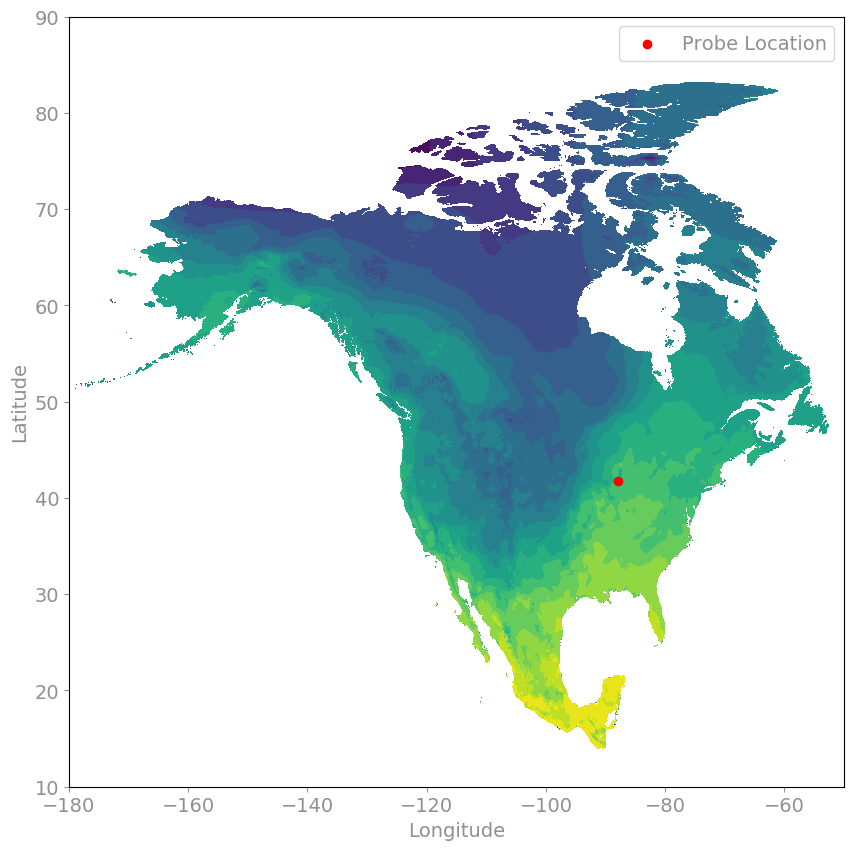

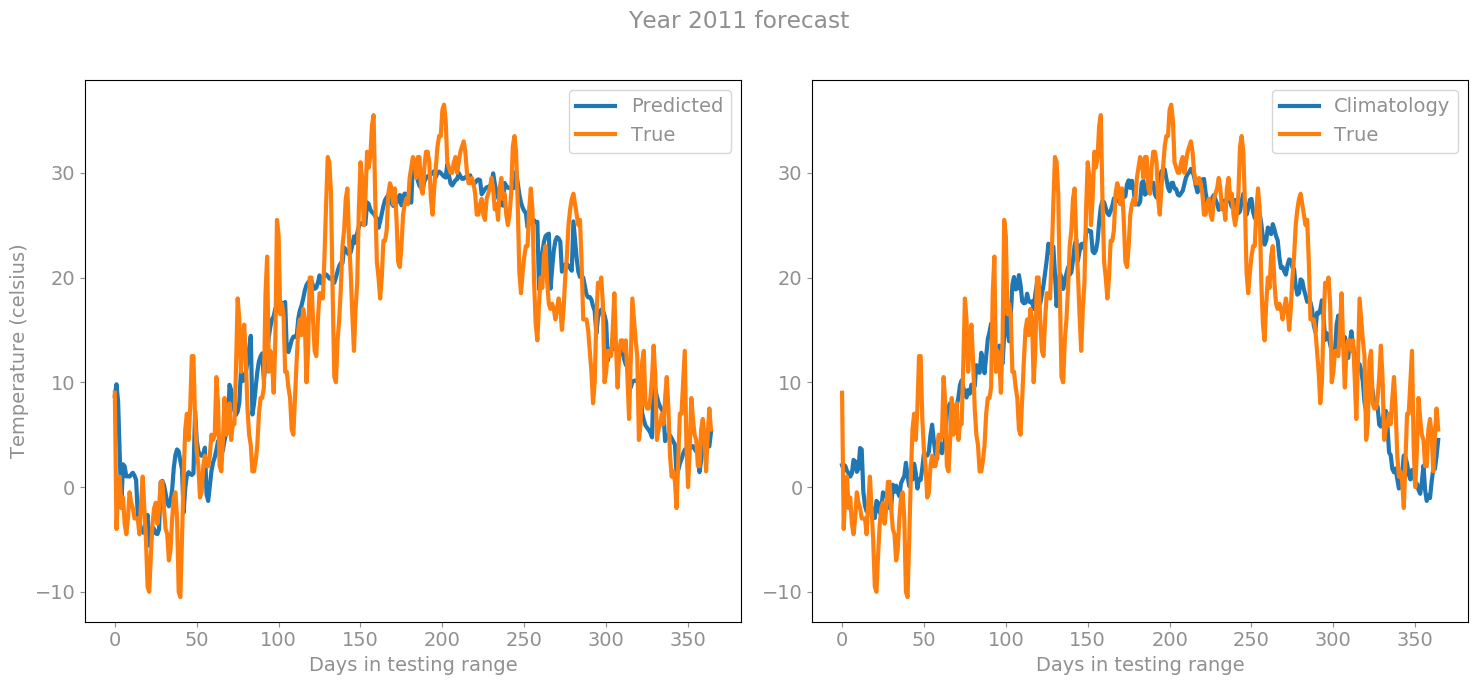

Predicted cosine similarity: 0.9725680599134341
Climatology cosine similarity: 0.965880644788921


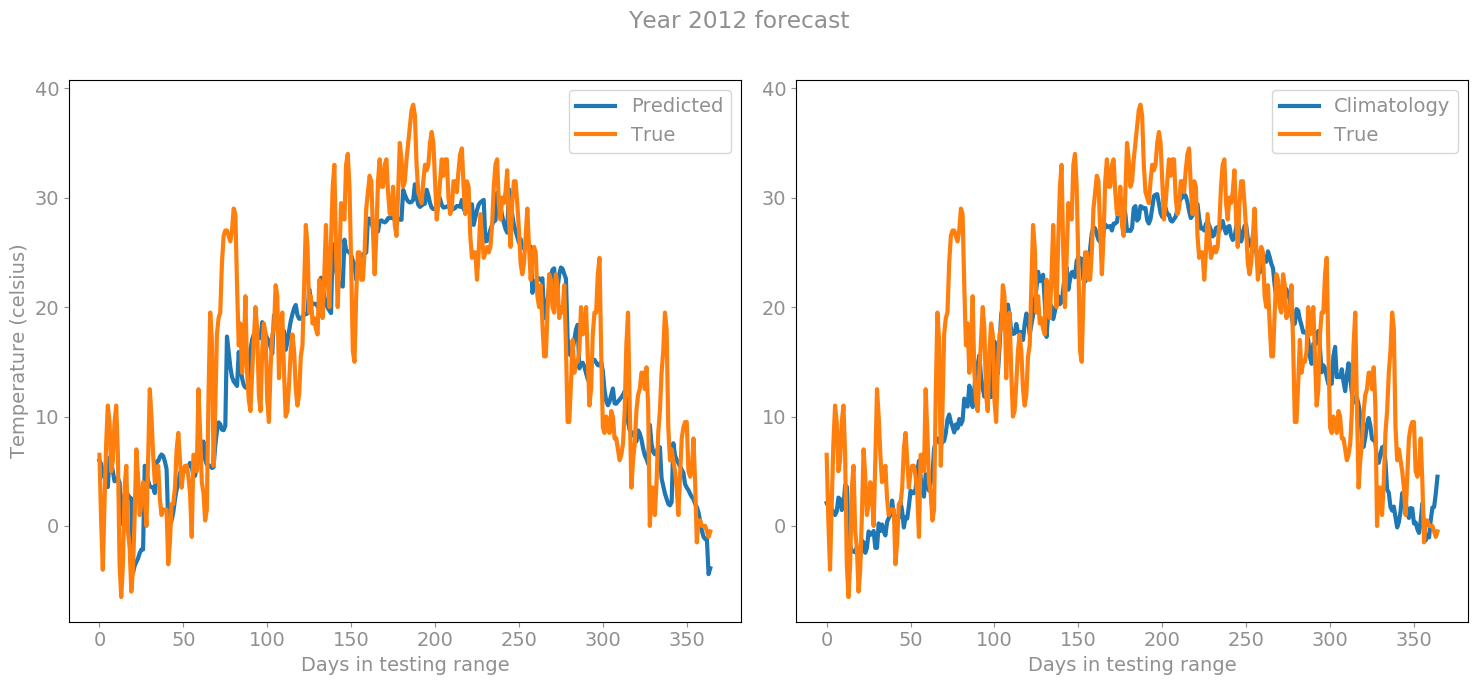

Predicted cosine similarity: 0.9706792457309561
Climatology cosine similarity: 0.9615263764678463


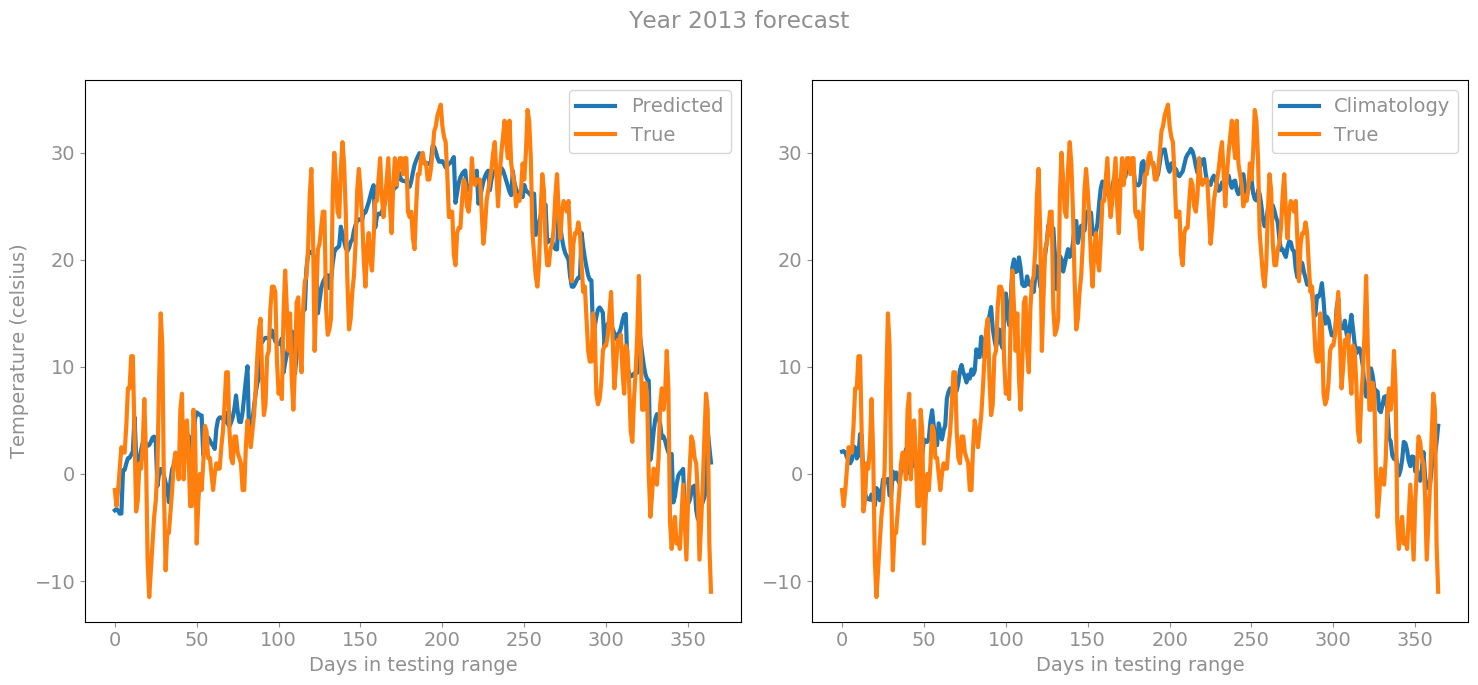

Predicted cosine similarity: 0.9696853400353879
Climatology cosine similarity: 0.9636657172475218


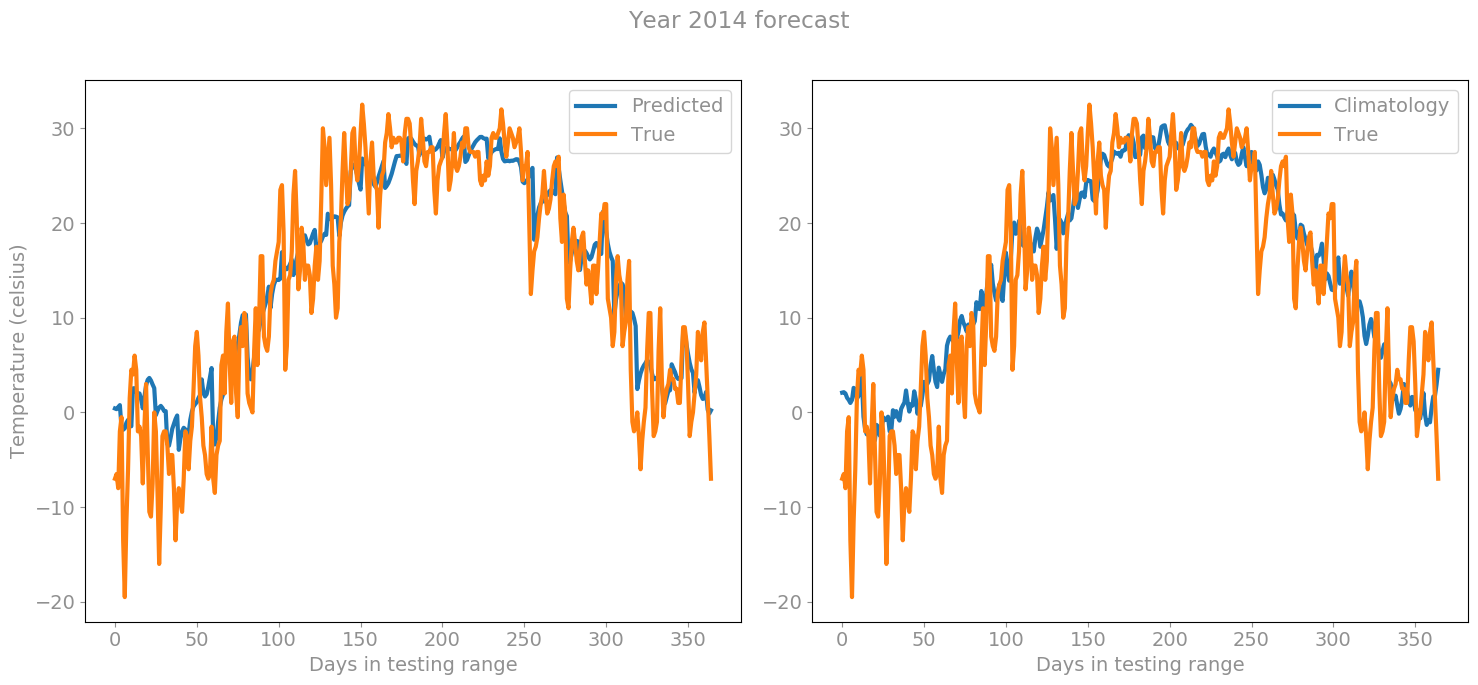

Predicted cosine similarity: 0.9669058278932193
Climatology cosine similarity: 0.955456655771694


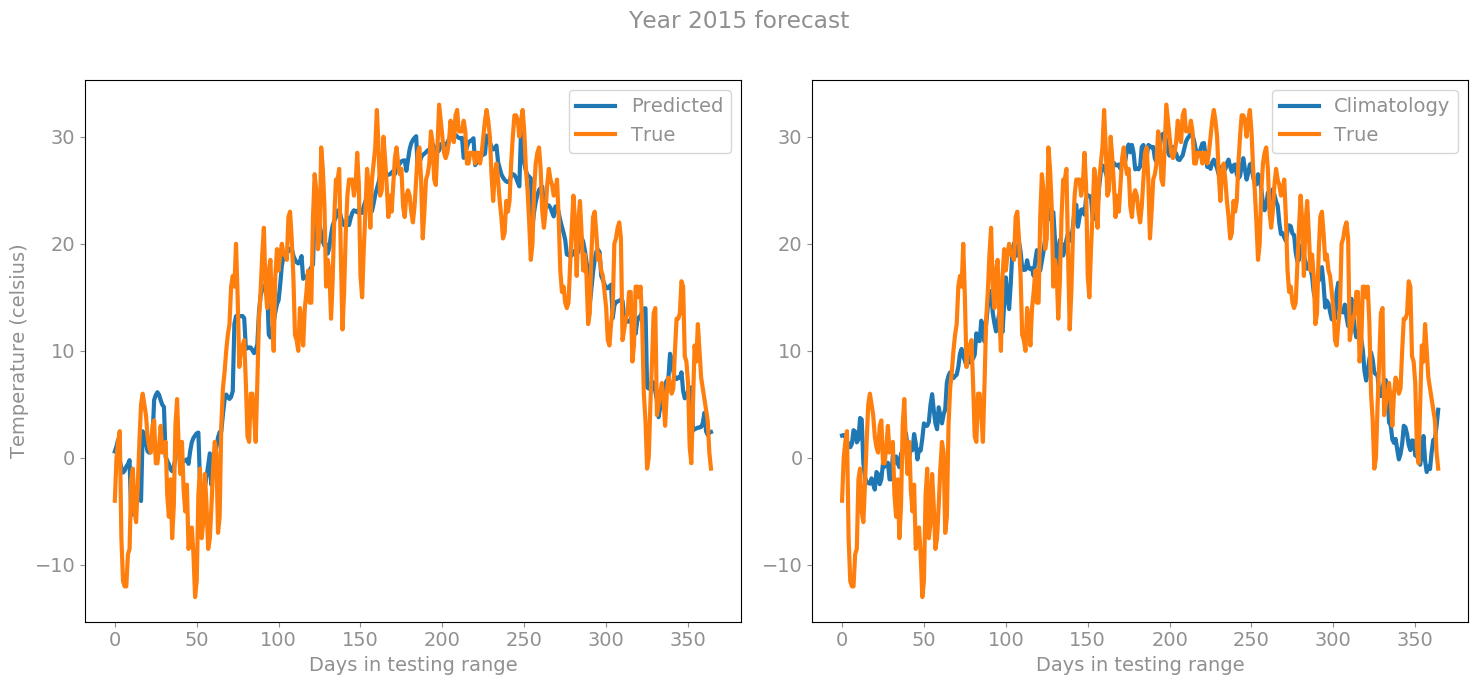

Predicted cosine similarity: 0.9739269588071848
Climatology cosine similarity: 0.9617343016138594


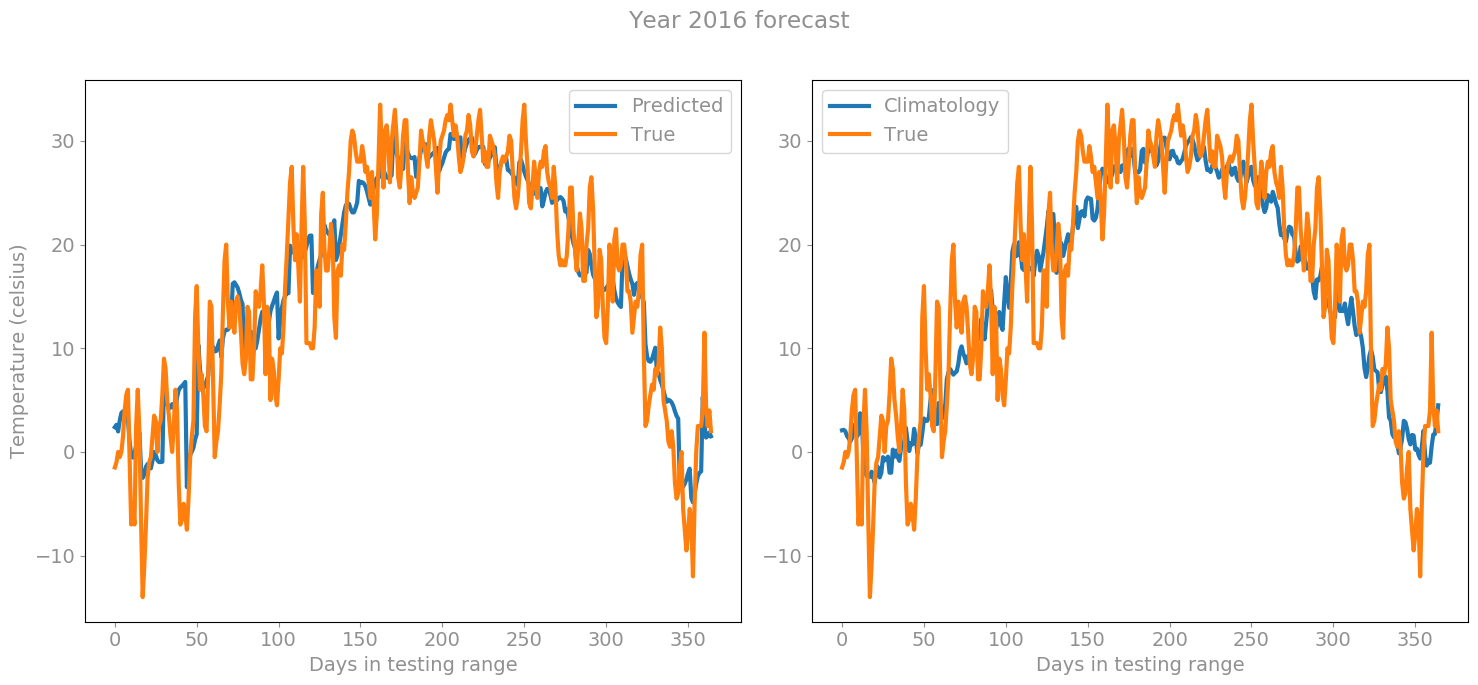

Predicted cosine similarity: 0.9775875347815822
Climatology cosine similarity: 0.9736547136136089


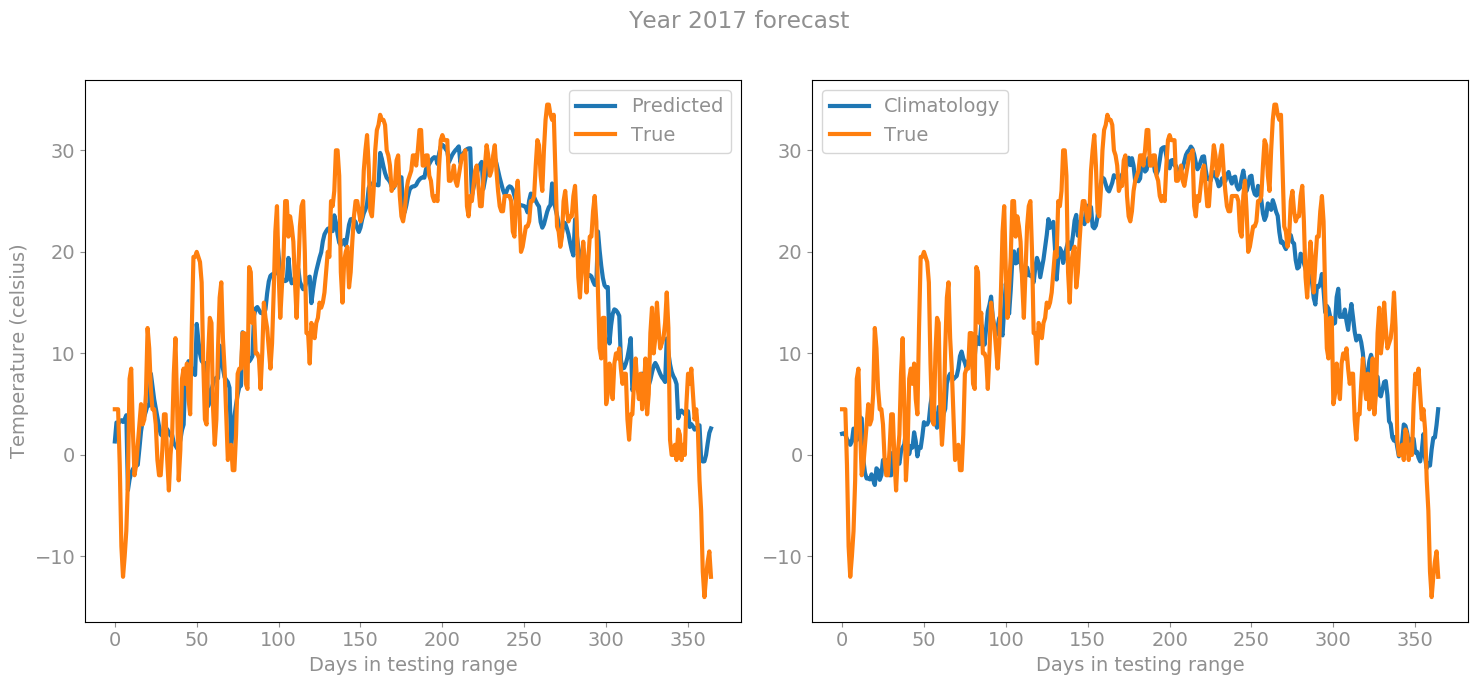

Predicted cosine similarity: 0.9690799794442646
Climatology cosine similarity: 0.9554046532548552


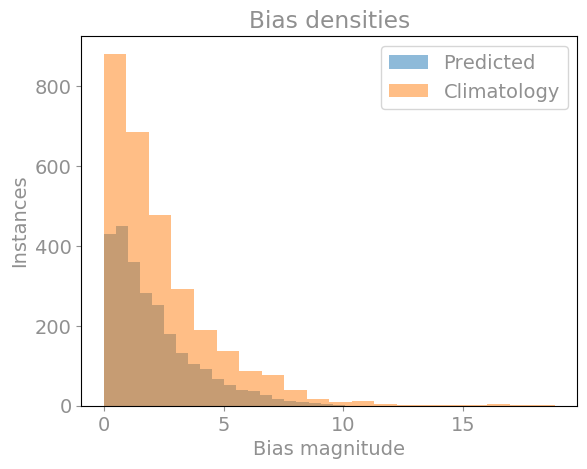

In [65]:
# Make probe of various land locations
y_loc = 499
x_loc = 551
probe_func(y_loc,x_loc,'Chicago')

Longitude: -95.45774
Latitude: 29.789146


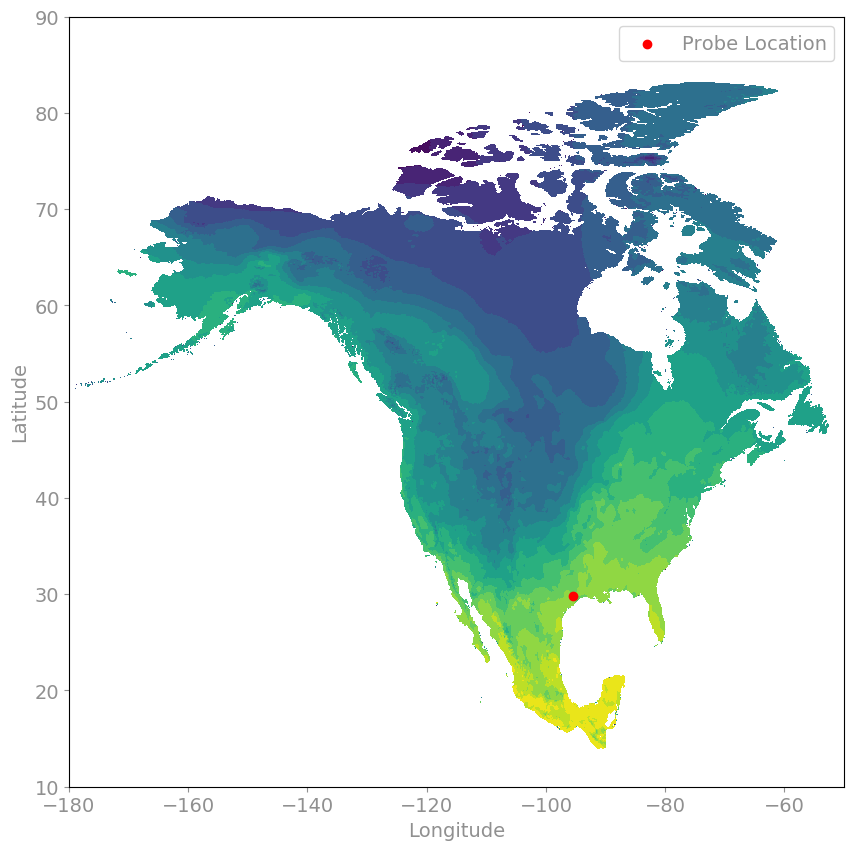

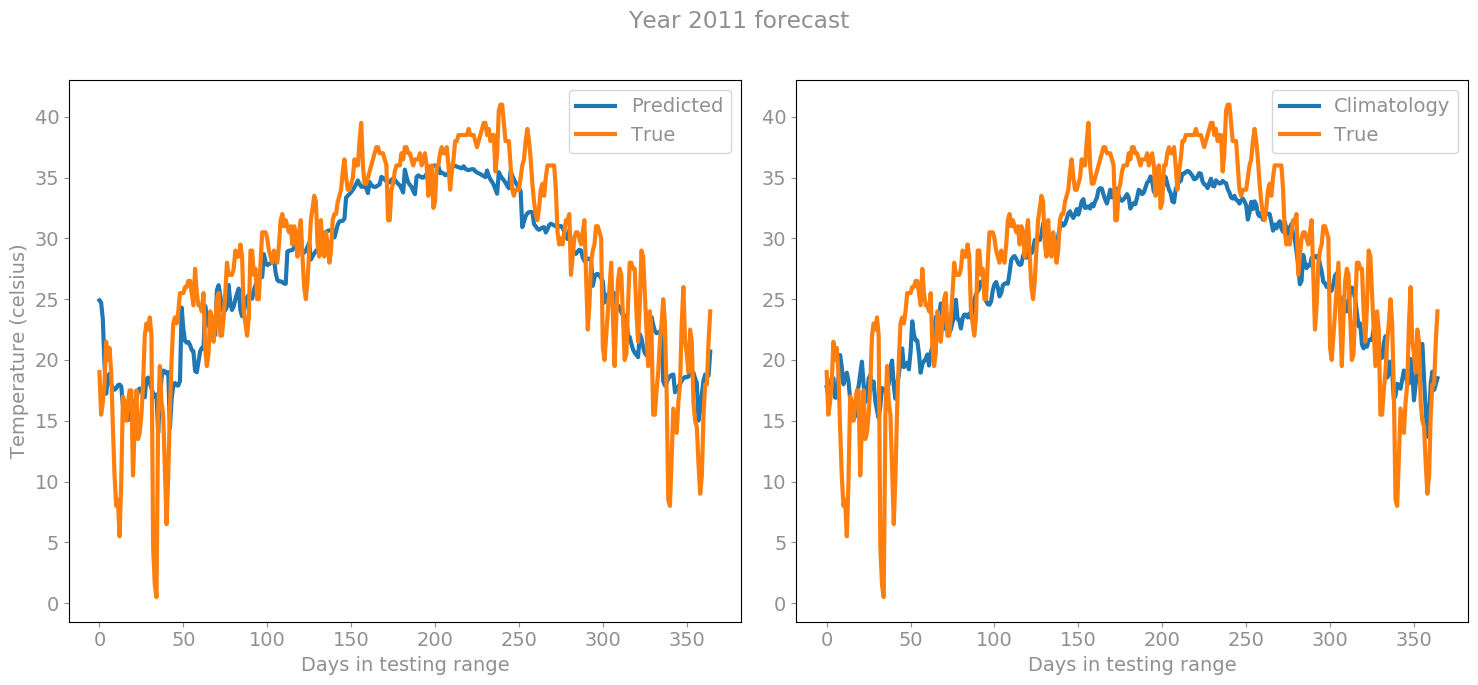

Predicted cosine similarity: 0.9919577983280999
Climatology cosine similarity: 0.99201971776296


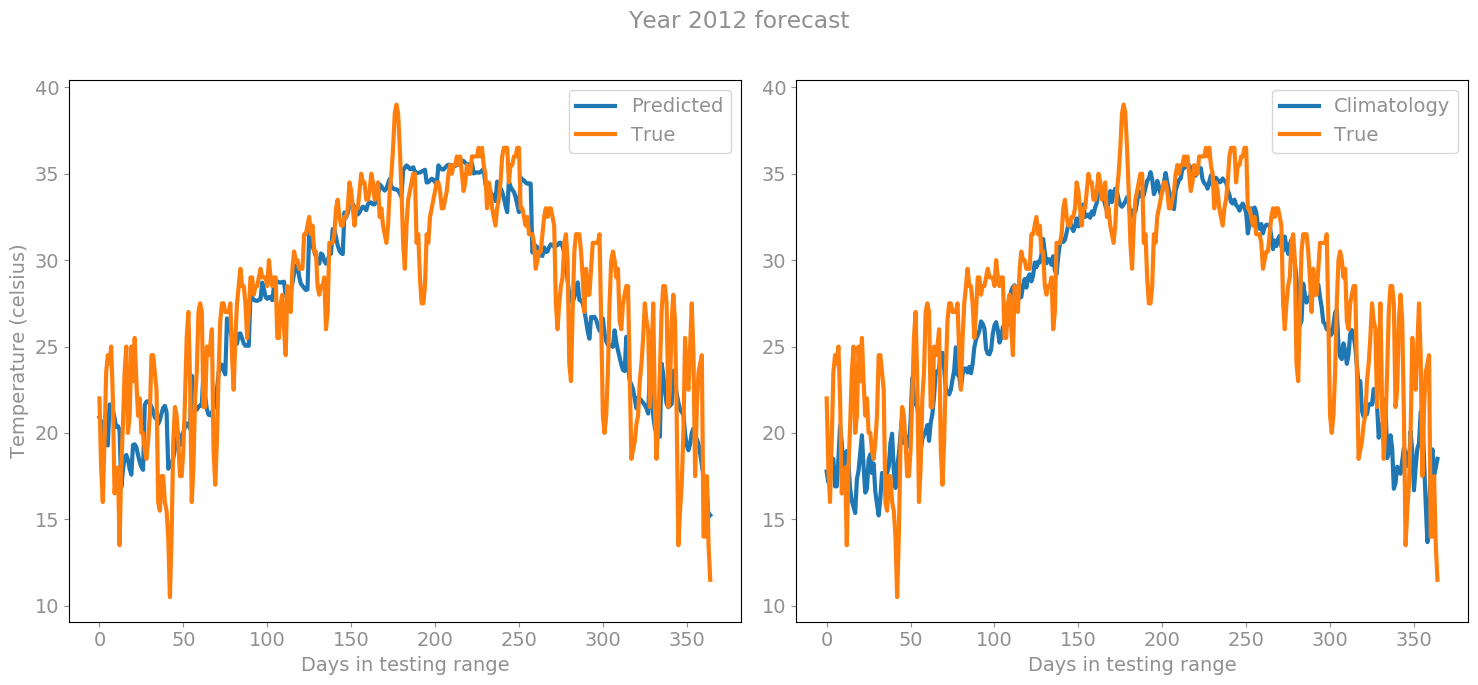

Predicted cosine similarity: 0.9944558086648659
Climatology cosine similarity: 0.9928528556200791


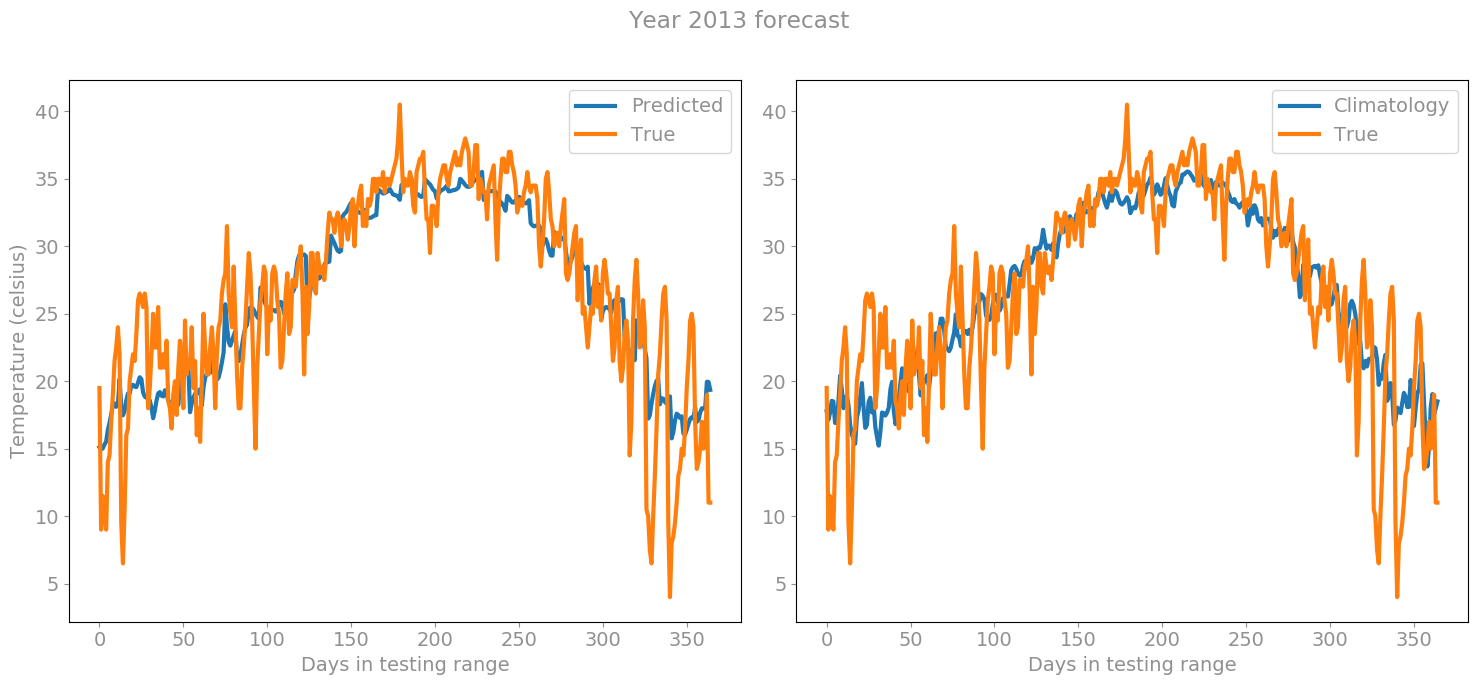

Predicted cosine similarity: 0.9919277669250507
Climatology cosine similarity: 0.9900040470769502


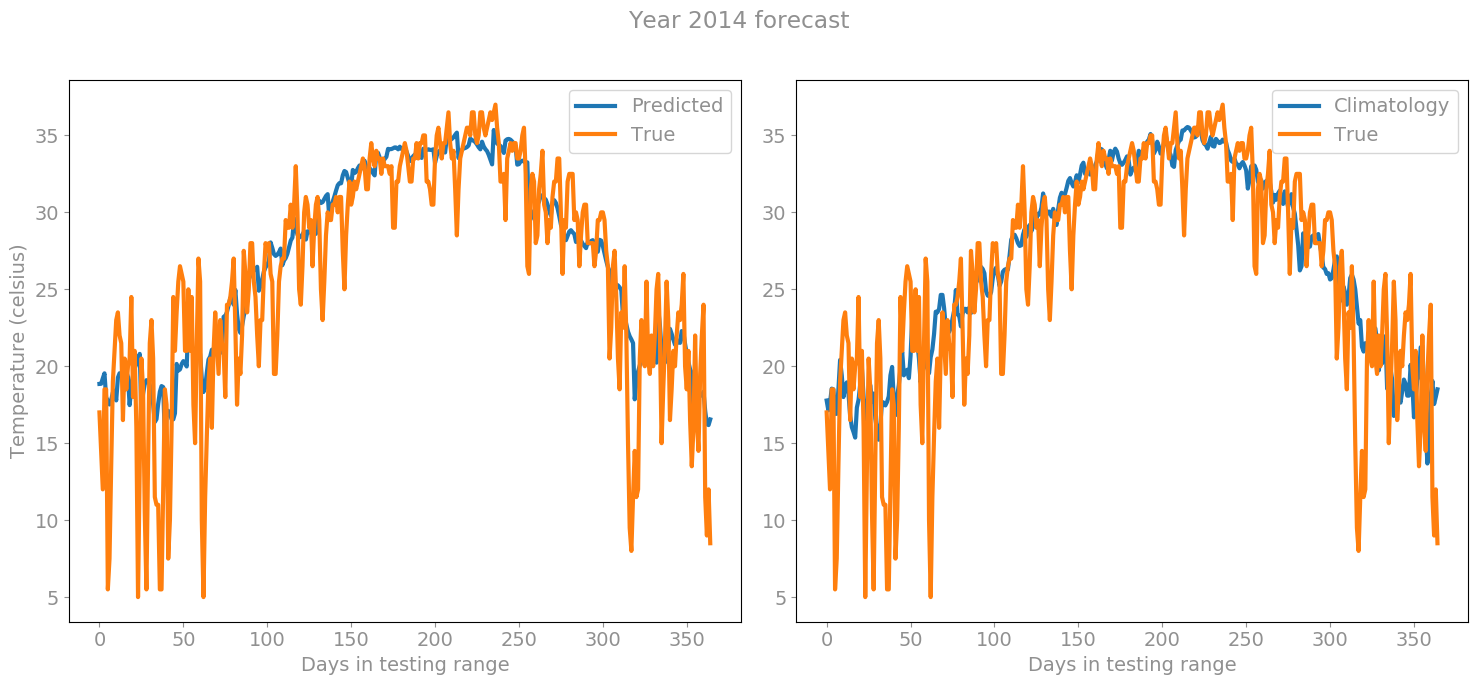

Predicted cosine similarity: 0.9910076161144933
Climatology cosine similarity: 0.9897729451305289


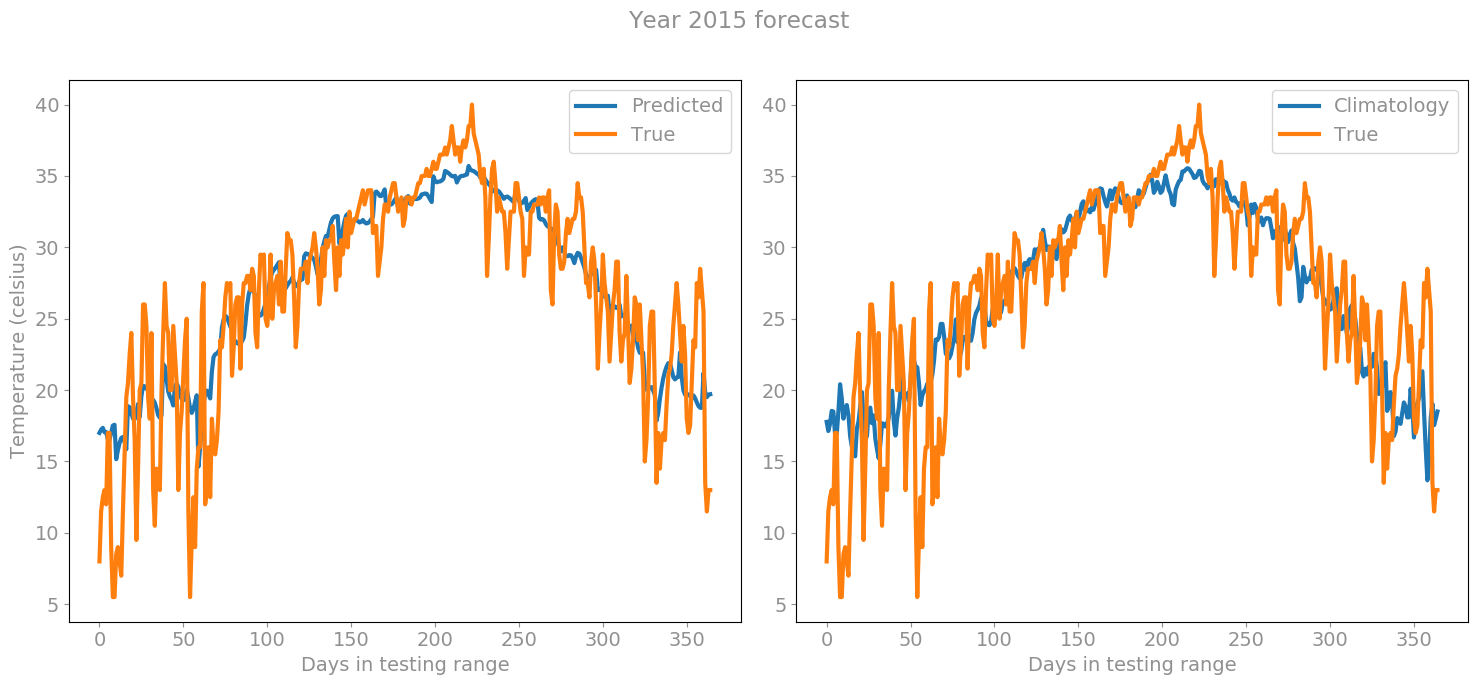

Predicted cosine similarity: 0.9918926941562807
Climatology cosine similarity: 0.988715695693955


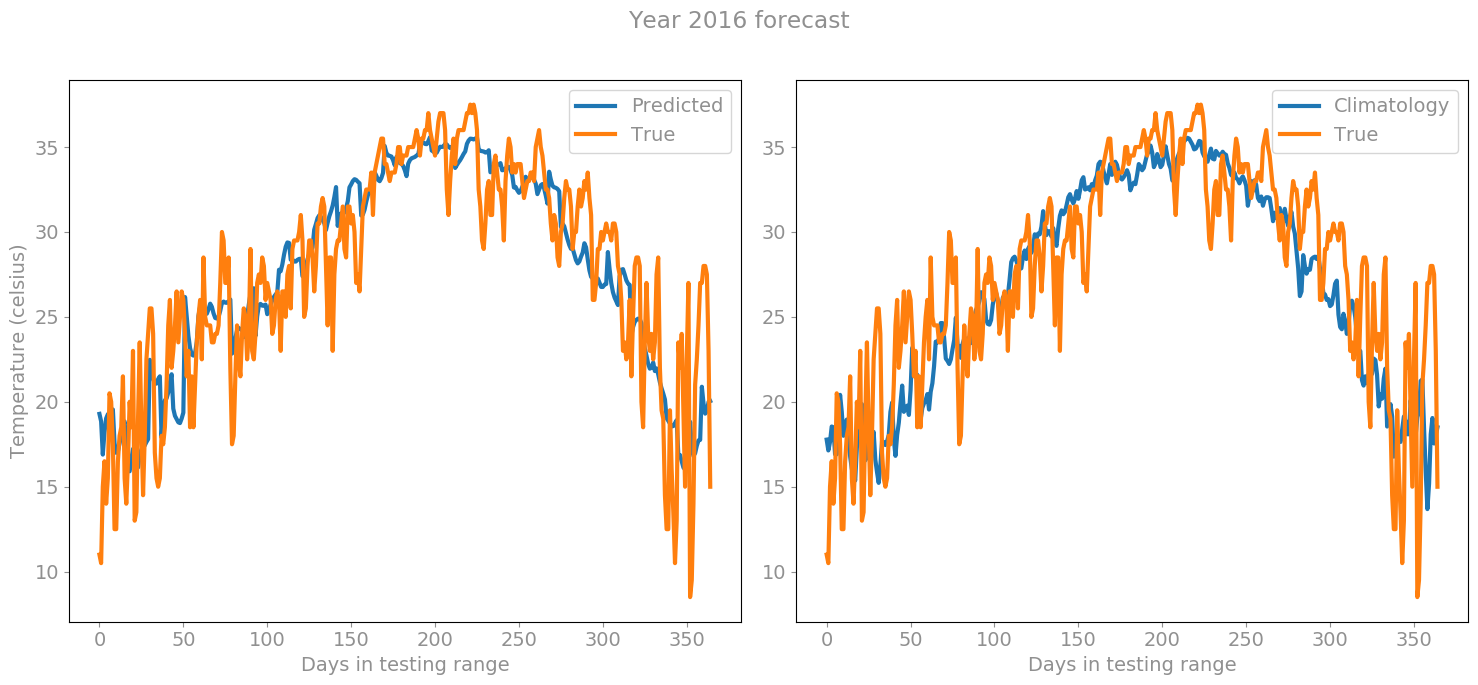

Predicted cosine similarity: 0.9934522112821756
Climatology cosine similarity: 0.9921370255877936


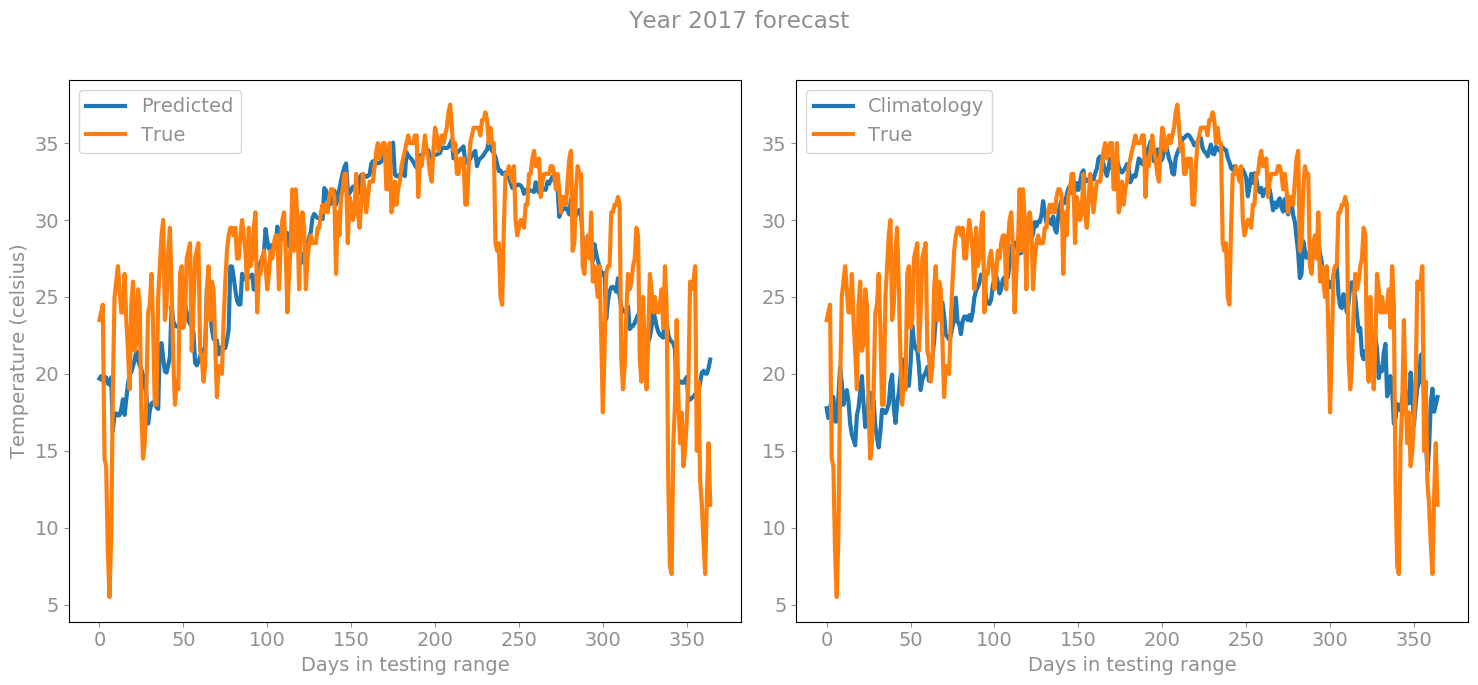

Predicted cosine similarity: 0.991134052989055
Climatology cosine similarity: 0.9899511579722234


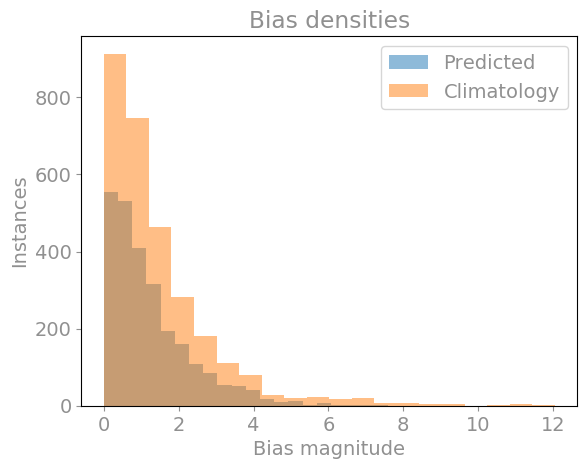

In [66]:
y_loc = 633
x_loc = 499
probe_func(y_loc,x_loc,'Houston')

Longitude: -77.00392
Latitude: 39.72594


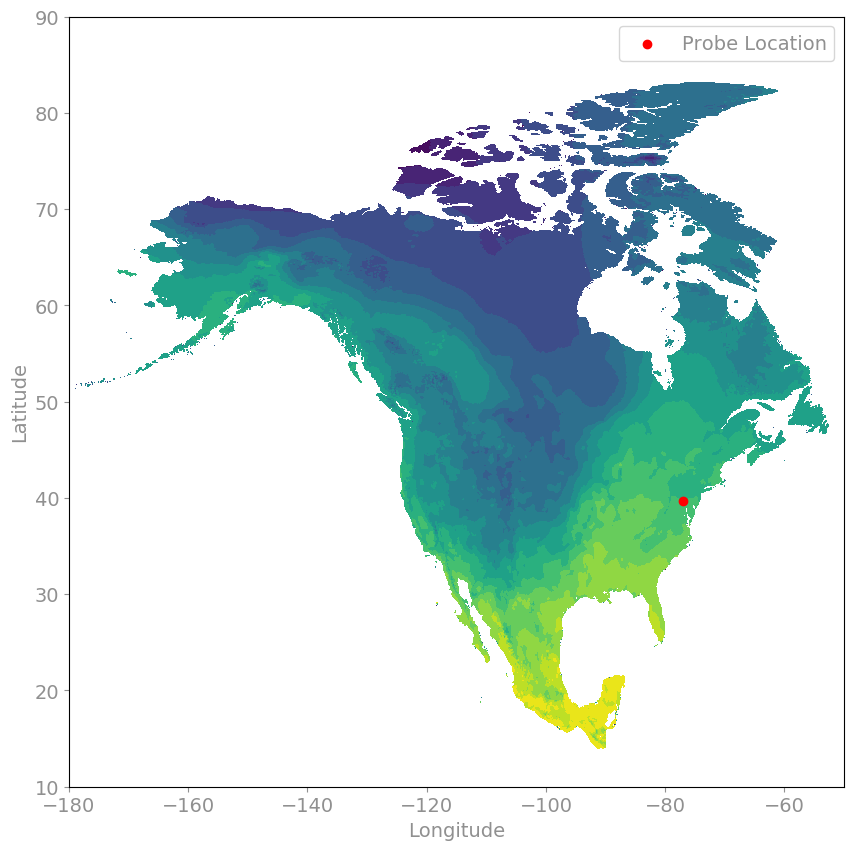

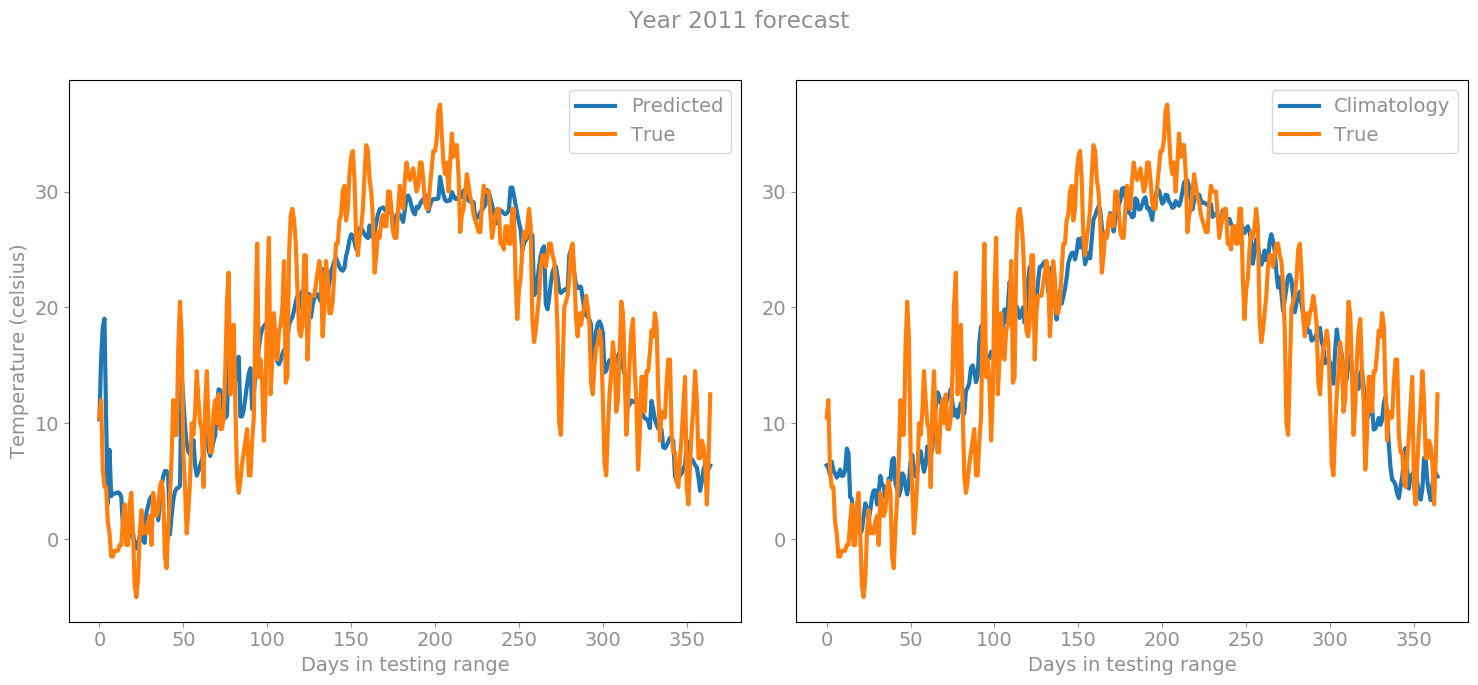

Predicted cosine similarity: 0.9780354468265037
Climatology cosine similarity: 0.9762486904684073


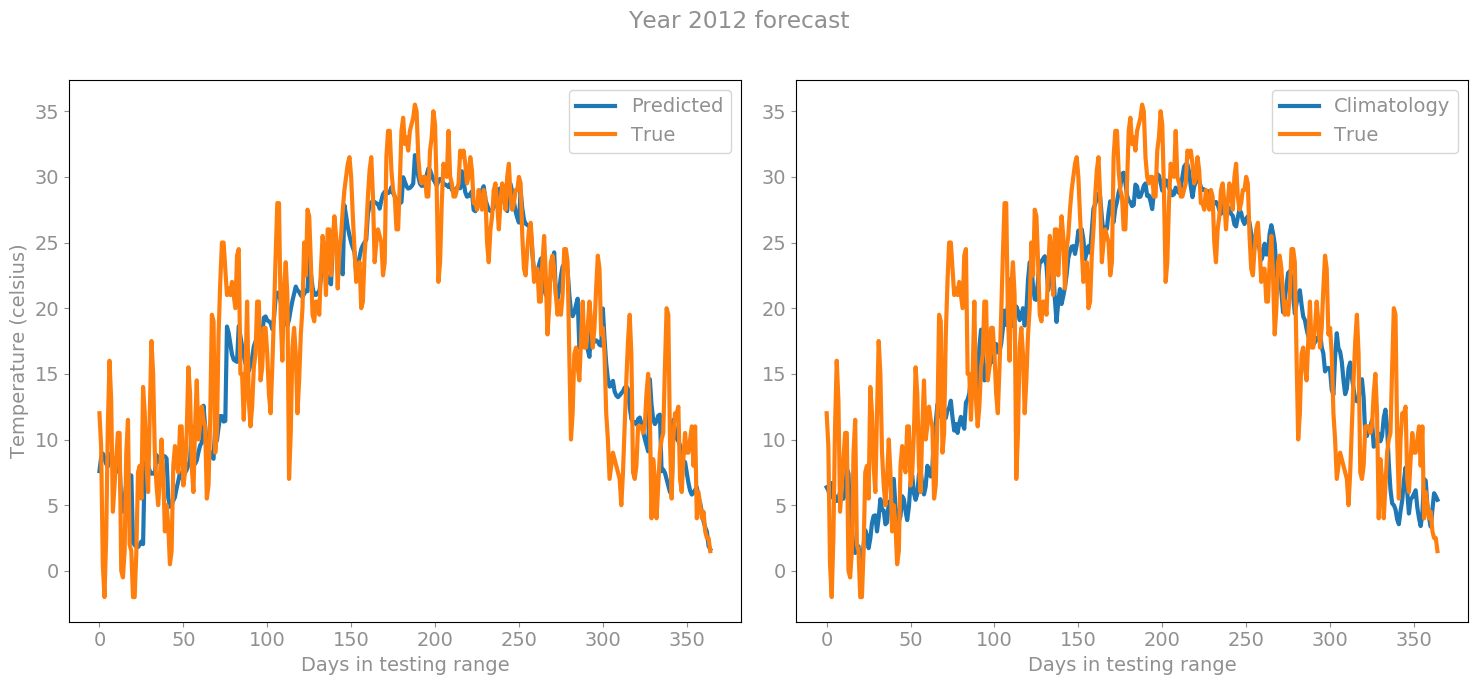

Predicted cosine similarity: 0.9807083804944496
Climatology cosine similarity: 0.972632629841184


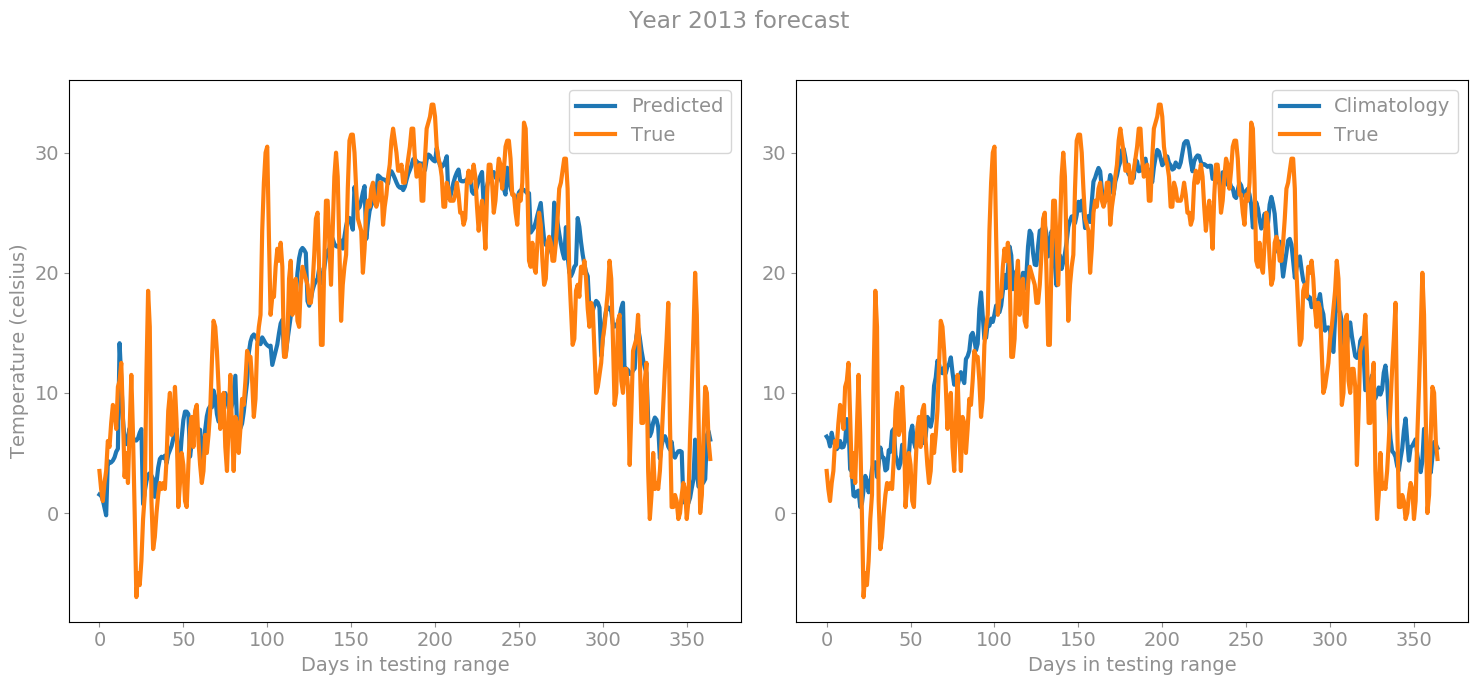

Predicted cosine similarity: 0.9757661503413272
Climatology cosine similarity: 0.9736021341299633


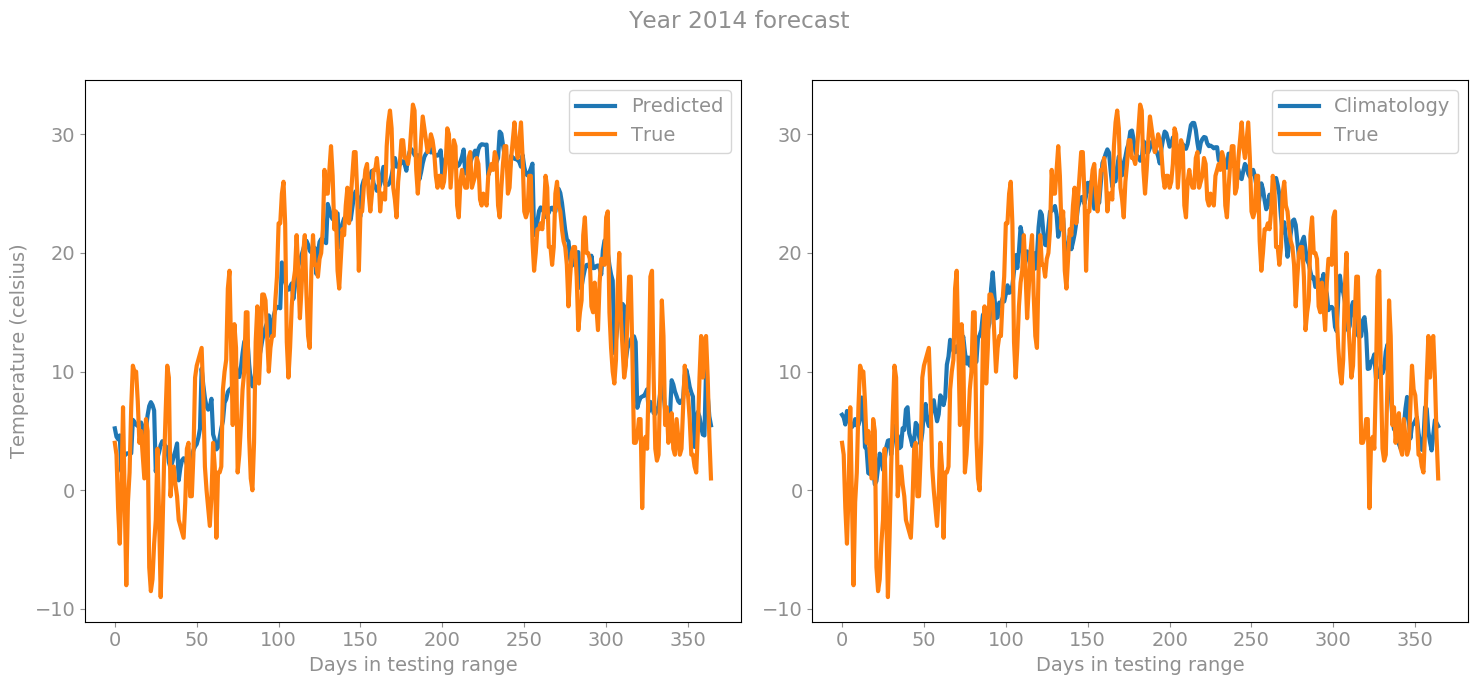

Predicted cosine similarity: 0.9769635048042326
Climatology cosine similarity: 0.9721906651486218


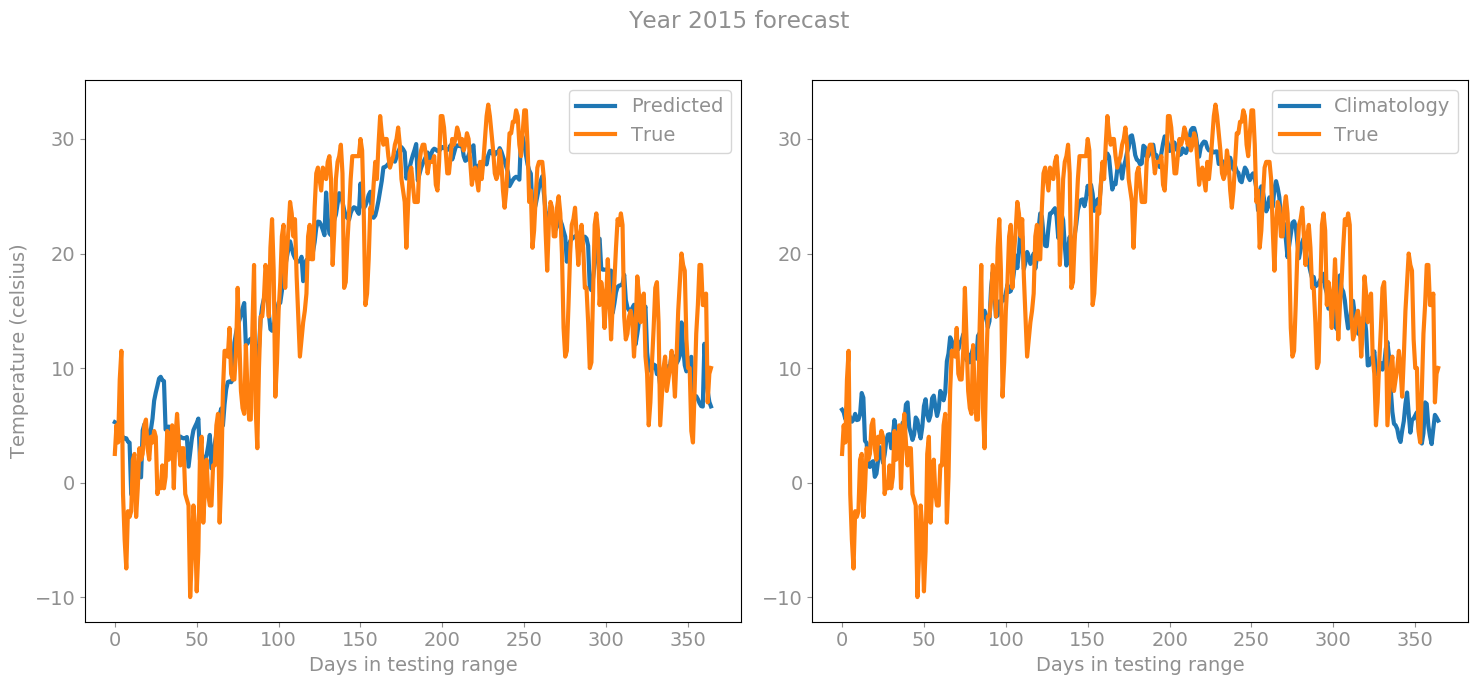

Predicted cosine similarity: 0.9783904350977622
Climatology cosine similarity: 0.9696547676527321


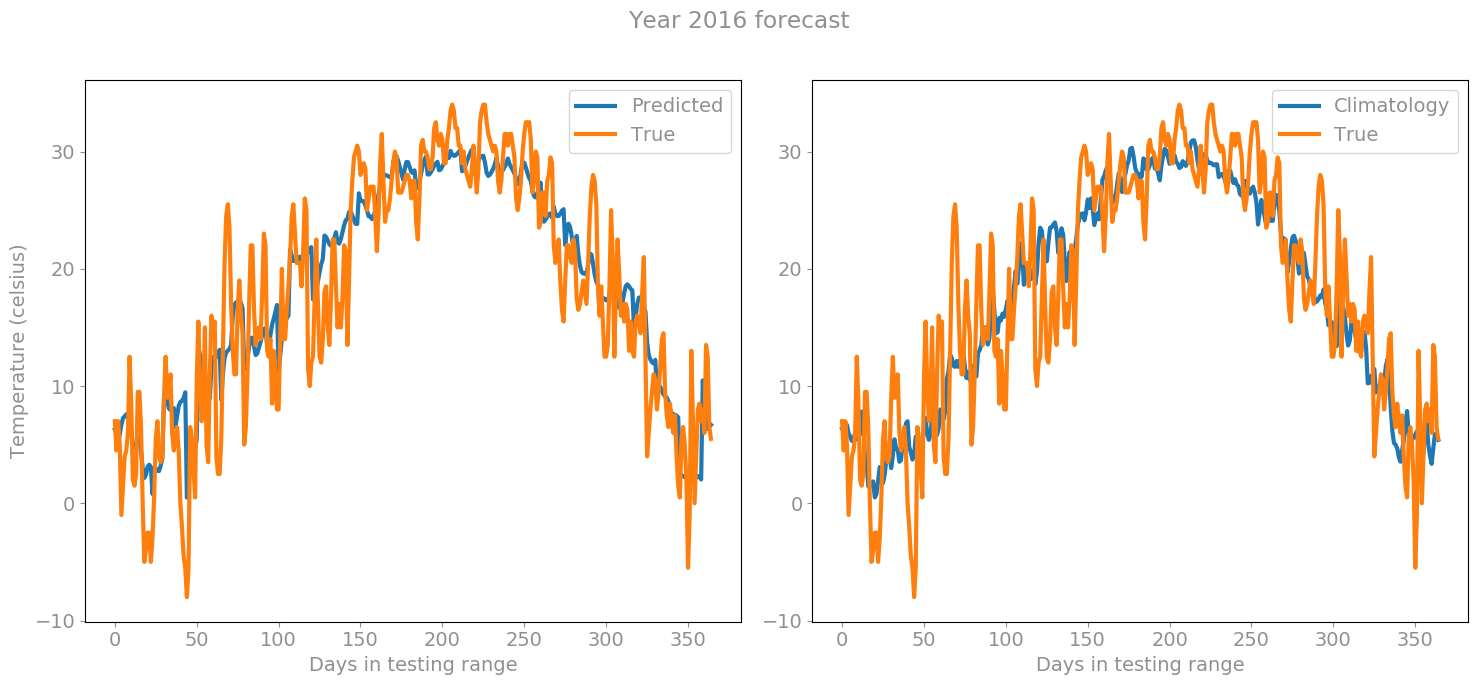

Predicted cosine similarity: 0.9788173073339628
Climatology cosine similarity: 0.9763872657587361


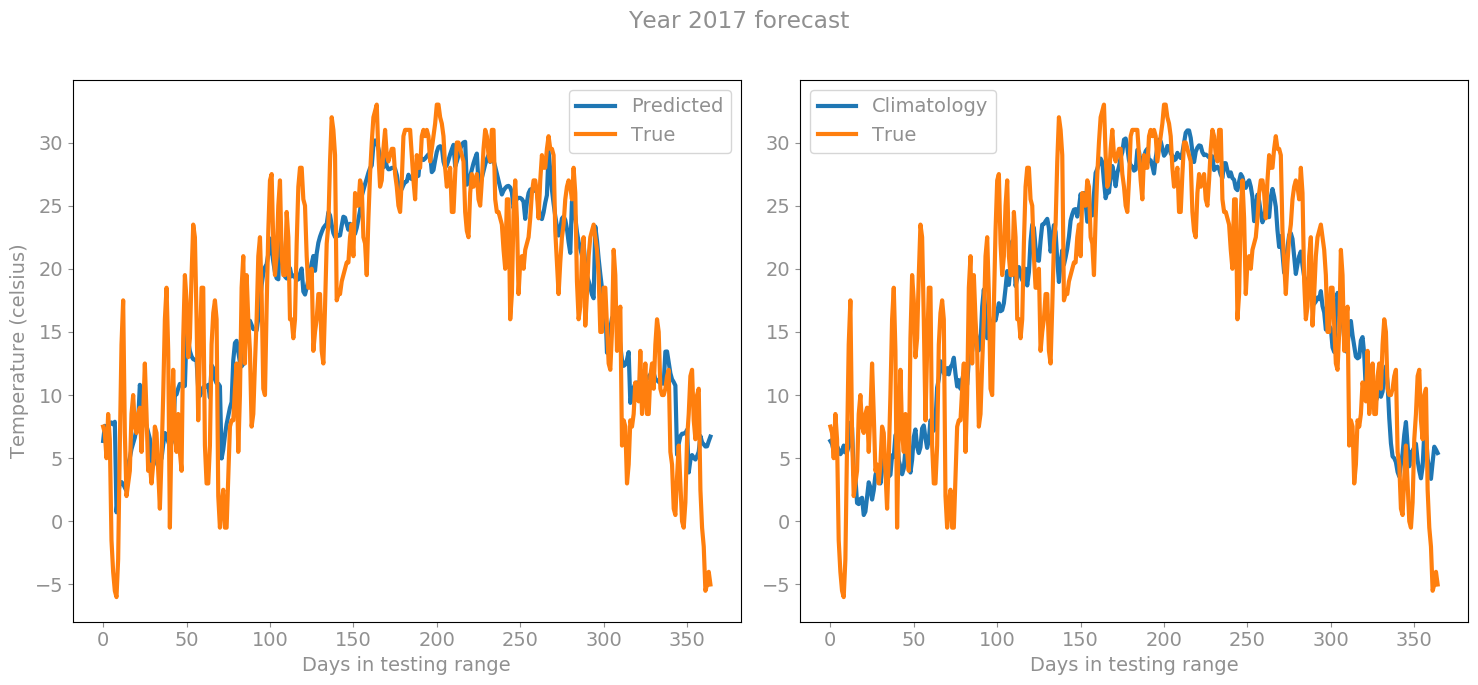

Predicted cosine similarity: 0.9745795243702817
Climatology cosine similarity: 0.9652269628348435


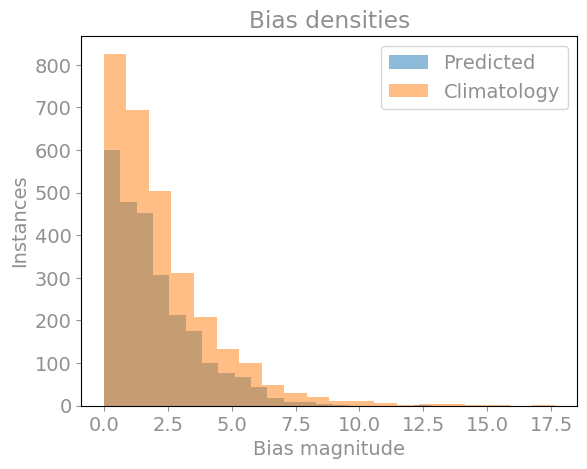

In [67]:
y_loc = 502
x_loc = 642
probe_func(y_loc,x_loc,'DC')

In [68]:
r_vals, p_vals = correlation_plot(year=0,int_start=90,int_end=180)

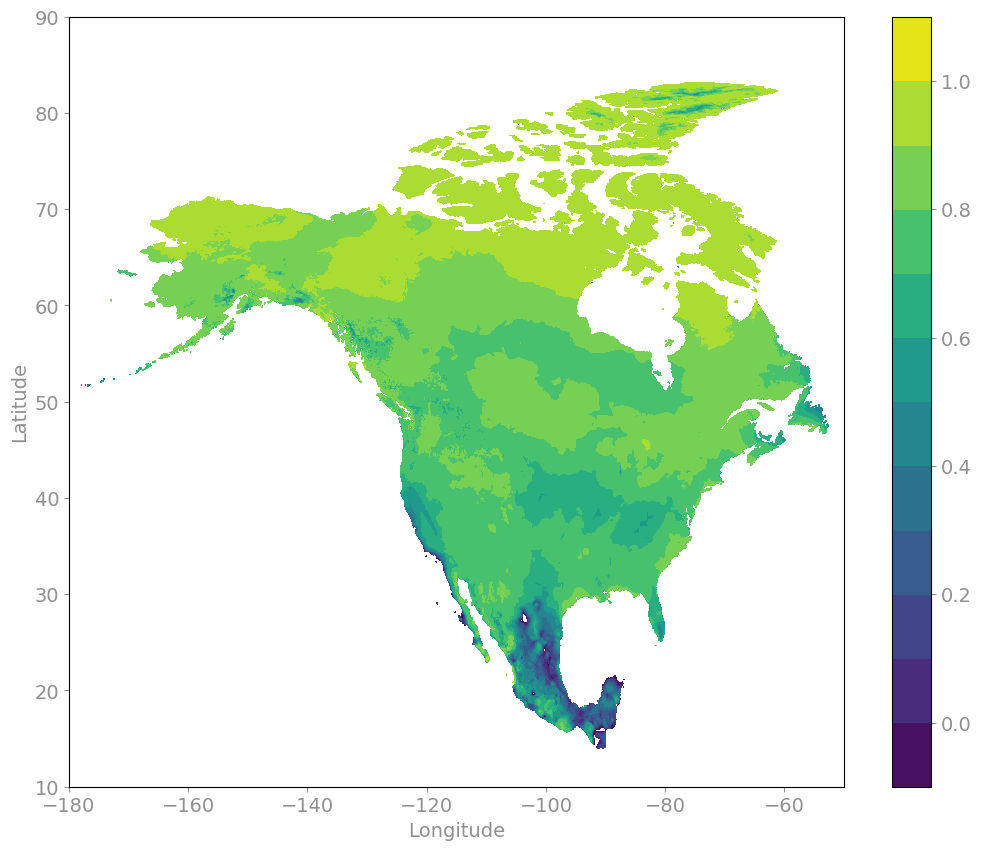

In [70]:
plt.figure(figsize=(12.5,10))
corr_levels = np.arange(-0.1,1.1,step=0.1)
plt.contourf(lons,lats,r_vals,levels=corr_levels)
plt.xlim((-180,-50))
plt.ylim((10,90))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.show()

In [30]:
import os
files = os.listdir('./Masks')
region_names = []
for file in files:
    if file.endswith('.nc'):
        region_name = file.split('.')[0]
        region_names.append(region_name)

In [52]:
# Function to perform analysis on true v predicted (same resolution)
def analyze_predictions(true_fields,pred_fields,region_name):
    print('Analyzing:',region_name)
    # load mask
    try:
        region_mask = np.load('./Masks/'+str(region_name)+'_mask.npy')
    except:
        print('Region does not exist')
        return None
    
    # Get some constants
    num_days = np.shape(true_fields)[0]
    
    # Get data points
    for i in range(num_days):
        region_temps = true_fields[i][region_mask]
        region_temps = region_temps[region_temps>-1000]
        
        if i == 0:
            true_data = np.copy(region_temps).reshape(1,-1)
        else:
            true_data = np.concatenate((true_data,region_temps.reshape(1,-1)),axis=0)

    # Get data points
    num_gp = np.shape(true_data)[-1]
    for i in range(num_days):
        region_temps = pred_fields[i][region_mask]
        region_temps = region_temps[region_temps>-1000]
        
        if i == 0:
            pred_data = np.copy(region_temps[:num_gp].reshape(1,-1))
        else:
            pred_data = np.concatenate((pred_data,region_temps[:num_gp].reshape(1,-1)),axis=0)
                
    # Get data points
    for i in range(num_days):
        region_temps = climatology[i][region_mask] # Already just one year
        region_temps = region_temps[region_temps>-1000]
        
        if i == 0:
            clim_data = np.copy(region_temps).reshape(1,-1)
        else:
            clim_data = np.concatenate((clim_data,region_temps.reshape(1,-1)),axis=0)
    
    # 7-day biases of regions
    bias_vals = []
    true_ave_temp_vals = []
    pred_ave_temp_vals = []
    
    for week in range(0,num_days//7):
        true_ave_temp = 0.0
        pred_ave_temp = 0.0

        for day in range(week*7,(week+1)*7):
            true_ave_temp = np.mean(true_data[day]) + true_ave_temp
            pred_ave_temp = np.mean(pred_data[day]) + pred_ave_temp

        true_ave_temp = true_ave_temp/7.0
        pred_ave_temp = pred_ave_temp/7.0

        true_ave_temp_vals.append(true_ave_temp)
        pred_ave_temp_vals.append(pred_ave_temp)
        bias_vals.append(true_ave_temp-pred_ave_temp)
        
        true_day_temps = true_data[week*7:(week+1)*7].flatten()
        clim_day_temps = clim_data[week*7:(week+1)*7].flatten()
        pred_day_temps = pred_data[week*7:(week+1)*7].flatten()
        
    plt.figure()
    plt.plot(np.arange(len(bias_vals)),bias_vals,'o')
    plt.xlabel('Week')
    plt.ylabel('Bias')
    plt.show()
    
    plt.figure()
    plt.plot(np.arange(len(true_ave_temp_vals)),true_ave_temp_vals,'o',label='True')
    plt.plot(np.arange(len(pred_ave_temp_vals)),pred_ave_temp_vals,'o',label='Predicted')
    plt.xlabel('Week')
    plt.ylabel('Weekly average forecasts')
    plt.legend()
    plt.show()

Analyzing: Central


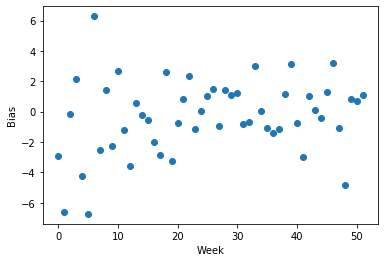

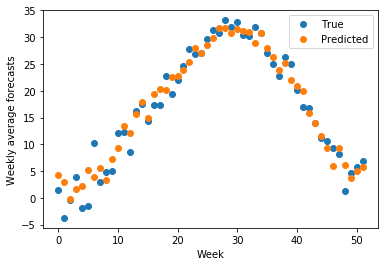

Analyzing: Central


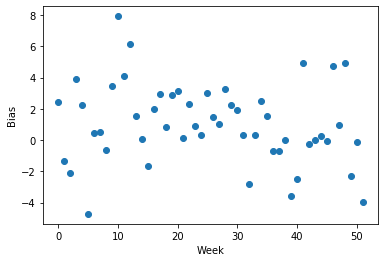

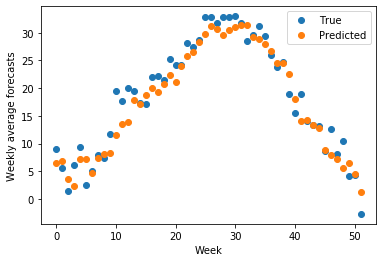

Analyzing: Central


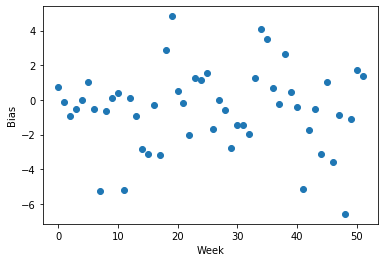

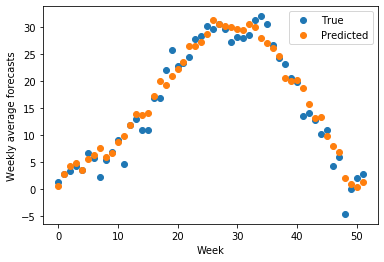

Analyzing: Central


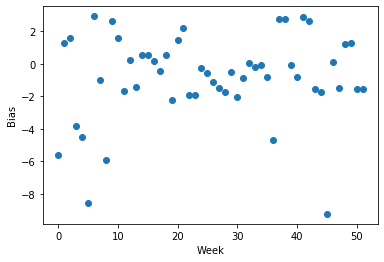

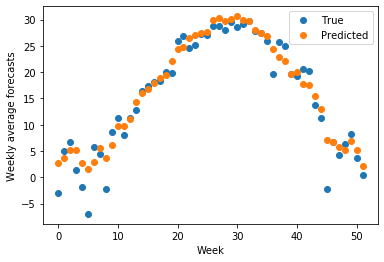

Analyzing: Central


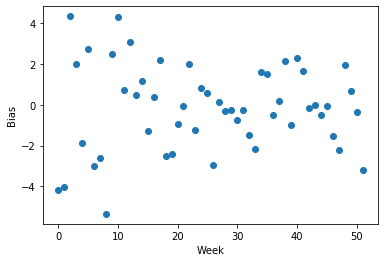

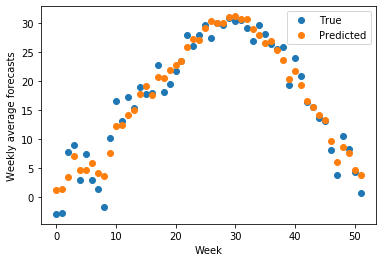

Analyzing: Central


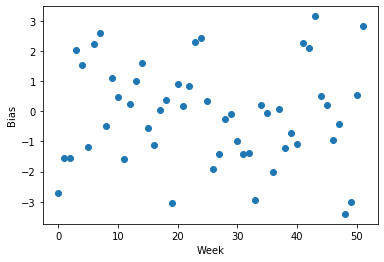

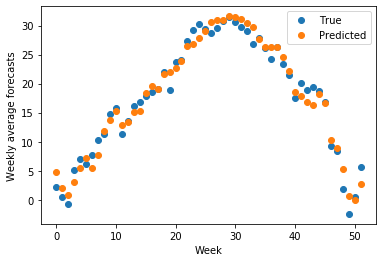

Analyzing: Central


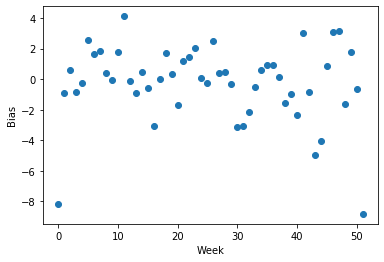

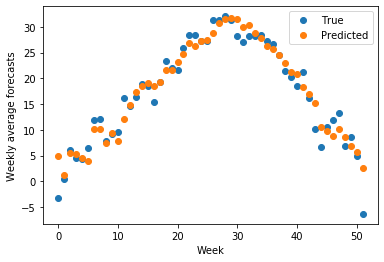

In [53]:
for test_year in range(7):
    true_test_year = true_snapshots[test_year*365:(test_year+1)*365]
    pred_test_year = snapshots_pred[test_year*365:(test_year+1)*365]
    analyze_predictions(true_test_year,pred_test_year,'Central')

Analyzing: MtWest


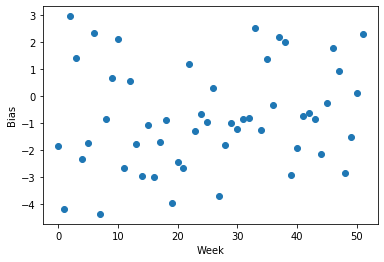

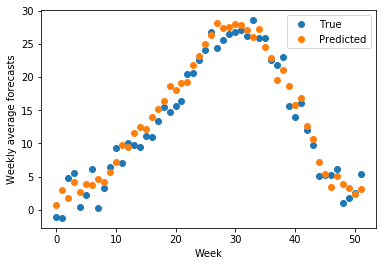

Analyzing: MtWest


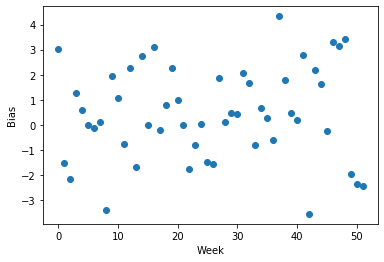

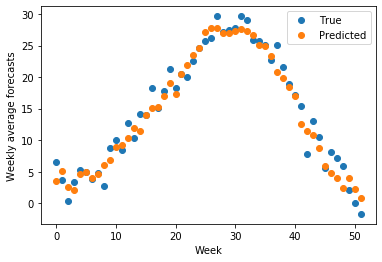

Analyzing: MtWest


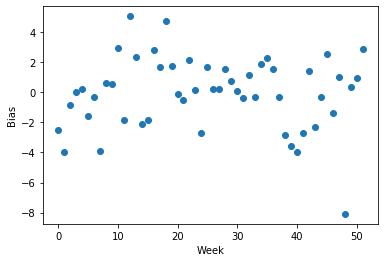

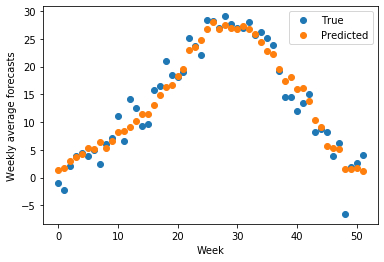

Analyzing: MtWest


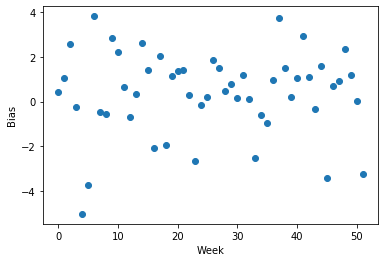

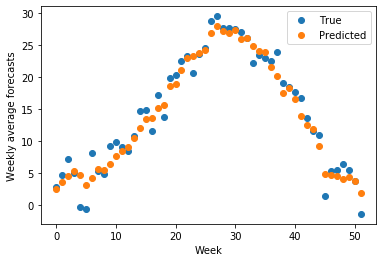

Analyzing: MtWest


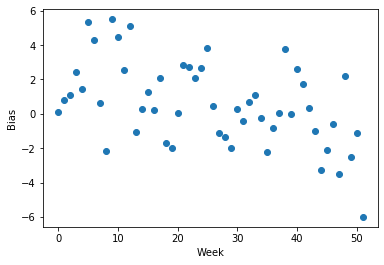

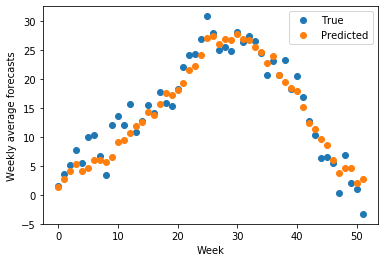

Analyzing: MtWest


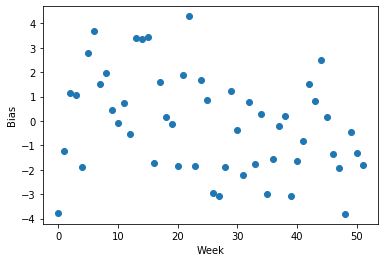

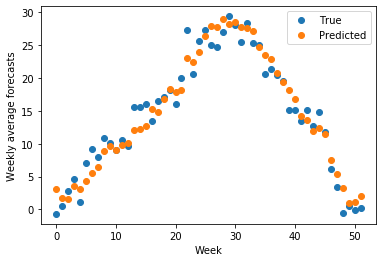

Analyzing: MtWest


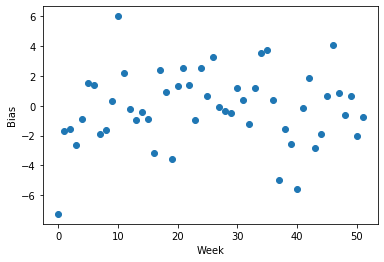

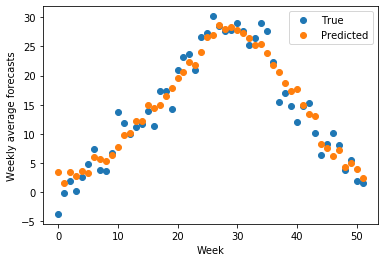

In [54]:
for test_year in range(7):
    true_test_year = true_snapshots[test_year*365:(test_year+1)*365]
    pred_test_year = snapshots_pred[test_year*365:(test_year+1)*365]
    analyze_predictions(true_test_year,pred_test_year,'MtWest')

In [34]:
region_names

['WestTaiga',
 'ColdNEPacific',
 'CentralTundra',
 'WetSouth',
 'Prairie',
 'Southeast',
 'GreatBasin',
 'ArcticLand',
 'South',
 'CPlains',
 'Hudson',
 'Desert',
 'Boreal',
 'PacificNW',
 'EastTundra',
 'NorthernNA',
 'MidAtlantic',
 'EastTaiga',
 'PacificSW',
 'Central',
 'DeepSouth',
 'EastCoast',
 'East',
 'ColdNWAtlantic',
 'Southwest',
 'Tundras',
 'NPlains',
 'NRockies',
 'GreatLakes',
 'Appalachia',
 'WarmNWAtlantic',
 'Greenland',
 'WarmNEPacific',
 'LabradorSea',
 'ArcticAll',
 'NorthAtlantic',
 'SPlains',
 'WestTundra',
 'MtWest',
 'GreatPlains',
 'Mezquital',
 'SRockies',
 'Rockies',
 'WestBoreal',
 'Taigas',
 'EastBoreal']